![techCompanies](images/tech_salaries_analysis.jpg) 

# Introduction
In a world where a cheeseburger no longer costs a quarter, or the even more dejecting reality that less and less of the affluent can afford personal yachts, the value of the dollar has become less and more concurrently.  Less valuable, because the purchasing power of the dollar has diminished, but more valuable because it is more important than ever to squeeze each dollar out of income sources.  In order to combat this reality, and add to the wealth of knowledge surrounding potentially increasing an individual’s income, we are analyzing the tech companies salary dataset.

This dataset consists of information corresponding to individuals with technology centered careers. The data includes general demographic information about the individual, such as education level, years of experience, sex, and race.  For income data, the dataset provides values for metrics such as base salary and total yearly compensation.  Examples of company level information provided include the name of the company and position.  
We will also be merging the dataset with a dataset of current stock market statistics.  This will focus our population on United States based public companies, which in turn will create a more accurate and useful model. This dataset will allow us to analyze variables like the market cap group, a categorical grouping of companies based on the number of outstanding shares multiplied by the stock price.  Other metrics include the number of employees currently employed by the company, the revenue per employee generated, the industry of the company, the sector of the company, and debt growth year over year.

# Objectives
The purpose of our exploration is to find what variables have an impact on tech centered career salaries, how strong the impact of those variables are, and make a prediction as to what salary an individual can potentially expect based on the value of variables that have an impact on salary.  The expectations of this analysis are that variables such as years of experience, market cap group, and revenue per employee have a strong influence on predicting the salary of an individual.

# Stakeholders
As for the stakeholders of our analysis, any individual, current or potential, looking to apply for tech related positions can use our analysis to focus their job search efforts using the metrics that have been found to be most effective in predicting salary to increase their potential salary.  This analysis can be bought or funded by companies similar to LinkedIn, who have a large stake in the analysis and trends of the job market. By gaining a better understanding of the driving factors of salaries, companies can implement initiatives to attract certain markets, ultimately contributing to the overall growth of the industry and the economy at large. 

# Research Questions
The main question we want to answer is what variables can influence the salary of an individual with a technology centered career in the United States.  Finding an answer to this question will give an individual the ability to tailor career decisions in a way to increase the probability of receiving a higher level of compensation.  We expect that the most influential factors include the years of experience an individual has, the size of the company they are working in, and the revenue generated by the company.  This will be analyzed through correlation statistics throughout the data analysis process.

We would like to also answer the question of how strong of a relationship do significant variables have in predicting one’s income within technology centric careers based in the United States.  We expect years of experience to have the largest impact in predicting one’s income.  In order to test this hypothesis, we will be looking at the correlation statistics between years of experience and base salary, as well as the value of the calculated coefficient of years of experience in a multivariate linear regression model.


![processing](images/data_processing1.png) 

In [1]:
# Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import copy, math
from Matts_Utils import standardize
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import scale

In [2]:
# Load the dataset
df = pd.read_csv('datasets/tech_companies_salary.csv')
df.shape

(62642, 29)

In [3]:
df.head(3)

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education
0,06-07-2017 11:33,Oracle,L3,Product Manager,127000,"Redwood City, CA",1.5,1.5,NaN,107000,...,0,0,0,0,0,0,0,0,NaN,NaN
1,06-10-2017 17:11,eBay,SE 2,Software Engineer,100000,"San Francisco, CA",5.0,3.0,NaN,0,...,0,0,0,0,0,0,0,0,NaN,NaN
2,06-11-2017 14:53,Amazon,L7,Product Manager,310000,"Seattle, WA",8.0,0.0,NaN,155000,...,0,0,0,0,0,0,0,0,NaN,NaN


In [4]:
# Number of null values in each column
df.isna().sum()

timestamp                      0
company                        5
level                        123
title                          0
totalyearlycompensation        0
location                       0
yearsofexperience              0
yearsatcompany                 0
tag                          870
basesalary                     0
stockgrantvalue                0
bonus                          0
gender                     19540
otherdetails               22508
cityid                         0
dmaid                          2
rowNumber                      0
Masters_Degree                 0
Bachelors_Degree               0
Doctorate_Degree               0
Highschool                     0
Some_College                   0
Race_Asian                     0
Race_White                     0
Race_Two_Or_More               0
Race_Black                     0
Race_Hispanic                  0
Race                       40215
Education                  32272
dtype: int64

### Dropping categorical data with null values

>Dropping the data with null values in the gender, education, company, race, tag, and level columns, cleans up the data in order to look at the relationship of these variables on salaries.  

>These values cannot be replaced without adversely affecting other category values.

In [5]:
# Remove rows with null values in subset columns
df = df.dropna(subset=['gender', 'Education', 'company', 'Race', 'tag', 'level'])
df.shape

(21515, 29)

## Function to split the location column into city and state columns.

Locations with more than 2 strings delimited by a comma will be set to null values.  These locations correspond to locations outside of the United States.

Limiting our scope of the data to within the U.S. will increase the accuracy and usefulness of our model, as well as eliminate some outliers in the data.

In [6]:
def split_location(loc):
    location = loc.split(', ')  
    if len(location) == 2:
        city = location[0]
        state = location[1]
    else:
        city = None
        state = None
    return pd.Series([city, state])

# apply function to dataframe
df[['City', 'State']] = df['location'].apply(split_location)
# Remove rows with null values in State column
df = df.dropna(subset='State')

### Verification of Categorical Values

In [7]:
df.State.unique()

array(['CA', 'WA', 'TX', 'AZ', 'NY', 'IL', 'MA', 'NC', 'VA', 'CO', 'FL',
       'WI', 'DC', 'OR', 'MI', 'MN', 'MO', 'PA', 'UT', 'NJ', 'TN', 'LA',
       'GA', 'AR', 'IA', 'OH', 'MD', 'IN', 'MT', 'RI', 'DE', 'OK', 'NV',
       'CT', 'AL', 'SC', 'KS', 'KY', 'WV', 'MS', 'ID', 'NE', 'HI', 'NH',
       'NM', 'ND', 'VT', 'WY', 'ME'], dtype=object)

In [8]:
df.Education.unique()

array(['PhD', "Bachelor's Degree", "Master's Degree", 'Some College',
       'Highschool'], dtype=object)

In [9]:
df.Race.unique()

array(['Asian', 'Two Or More', 'White', 'Hispanic', 'Black'], dtype=object)

In [10]:
df.title.unique()

array(['Software Engineer', 'Software Engineering Manager',
       'Hardware Engineer', 'Product Designer', 'Management Consultant',
       'Product Manager', 'Solution Architect', 'Sales',
       'Technical Program Manager', 'Data Scientist', 'Recruiter',
       'Mechanical Engineer', 'Business Analyst', 'Human Resources',
       'Marketing'], dtype=object)

![stocks](images/stocks_data.png) 

In [11]:
stocks_df = pd.read_csv('datasets/screener-stocks.csv')
stocks_df.head(3)

,Symbol,Company Name,Market Cap,Stock Price,% Change,Industry,PE Ratio,Ent. Value,MC Group,Sector,...,Oper. Margin,Pretax Margin,Profit Margin,R&D / Rev,Avg. Volume,Rel. Volume,RSI,Tax / Revenue,Rev Gr. This Q,Rev Gr. Next Q
0,FLWS,1-800-FLOWERS.COM,6.965698e+08,10.92,1.11%,Specialty Retail,NaN,7.024748e+08,Small-Cap,Consumer Discretionary,...,-2.89%,-3.39%,-3.24%,3.20%,420598.0,77.96%,59.81,-0.15%,-5.95%,-3.19%
1,VCXB,10X Capital Venture Acquisition Corp. III,1.421026e+08,10.77,NaN,Shell Companies,63.35,1.420773e+08,Micro-Cap,Financials,...,NaN,NaN,NaN,NaN,10038.0,0.12%,60.96,NaN,NaN,NaN
2,TXG,10x Genomics,4.316825e+09,36.89,1.77%,Health Information Services,NaN,4.023500e+09,Mid-Cap,Healthcare,...,-42.88%,-40.21%,-41.23%,43.69%,1403080.0,74.62%,34.24,1.02%,7.41%,8.17%


In [12]:
# Reformatting company values to uppercase representation eliminates redundant values in the tech salaries datase
# This also provides a category for a merge of both datasets
df['company'] = df['company'].apply(lambda company: company.upper())
stocks_df['company'] = stocks_df['Company Name'].apply(lambda company: company.upper())

#Removal of the reference to ticker GOOGL, in order to merge data corresponding solely on ticker symbol GOOG.
stocks_df.drop(stocks_df.loc[stocks_df['Symbol']=='GOOGL'].index, inplace=True)

### Editing Company Names
>Here we are reassigning many of the most common company names in the tech salaries dataset.

>These values are being changed to a value that aligns with the company names in the screener stock dataset.

In [13]:
df.loc[ df['company'] == 'GOOGLE', 'company'] = 'ALPHABET'
df.loc[ df['company'] == 'AMAZON', 'company'] = 'AMAZON.COM'
df.loc[ df['company'] == 'FACEBOOK', 'company'] = 'META PLATFORMS'
df.loc[ df['company'] == 'PAYPAL', 'company'] = 'PAYPAL HOLDINGS'
df.loc[ df['company'] == 'HSBC', 'company'] = 'HSBC HOLDINGS'
df.loc[ df['company'] == 'APPLE INC.', 'company'] = 'APPLE'
df.loc[ df['company'] == '2U', 'company'] = '2U, INC.'
df.loc[ df['company'] == 'ABBOTT', 'company'] = 'ABBOTT LABORATORIES'
df.loc[ df['company'] == '8X8', 'company'] = '8X8, INC.'
df.loc[ df['company'] == 'ADP', 'company'] = 'Automatic Data Processing'.upper()
df.loc[ df['company'] == 'AFFIRM', 'company'] = 'AFFIRM HOLDINGS'
df.loc[ df['company'] == 'AMD', 'company'] = 'ADVANCED MICRO DEVICES'
df.loc[ df['company'] == 'INTEL CORPORATION', 'company'] = 'INTEL'
df.loc[ df['company'] == 'IBM', 'company'] = 'INTERNATIONAL BUSINESS MACHINES'
df.loc[ df['company'] == 'CAPITAL ONE', 'company'] = 'CAPITAL ONE FINANCIAL'
df.loc[ df['company'] == 'CISCO', 'company'] = 'CISCO SYSTEMS'
df.loc[ df['company'] == 'JPMORGAN CHASE', 'company'] = 'JPMORGAN CHASE & CO.'
df.loc[ df['company'] == 'JP MORGAN CHASE', 'company'] = 'JPMORGAN CHASE & CO.'
df.loc[ df['company'] == 'JP MORGAN', 'company'] = 'JPMORGAN CHASE & CO.'
df.loc[ df['company'] == 'UBER', 'company'] = 'UBER TECHNOLOGIES'
df.loc[ df['company'] == 'GOLDMAN SACHS', 'company'] = 'THE GOLDMAN SACHS GROUP'
df.loc[ df['company'] == 'WALMART LABS', 'company'] = 'WALMART'
df.loc[ df['company'] == 'EBAY', 'company'] = 'EBAY INC.'
df.loc[ df['company'] == 'VISA', 'company'] = 'VISA INC.'
df.loc[ df['company'] == 'LYFT', 'company'] = 'LYFT, INC.'
df.loc[ df['company'] == 'SAP', 'company'] = 'SAP SE'
df.loc[ df['company'] == 'DELL', 'company'] = 'DELL TECHNOLOGIES'
df.loc[ df['company'] == 'BOEING', 'company'] = 'THE BOEING COMPANY'
df.loc[ df['company'] == 'GENERAL MOTORS', 'company'] = 'GENERAL MOTORS COMPANY'
df.loc[ df['company'] == 'T-MOBILE', 'company'] = 'T-MOBILE US'

### Initial merge of the data sets

In [14]:
agg_df = pd.merge(df, stocks_df, on="company", how="left")


counts = agg_df['company'].value_counts()
print('Top 10 companies with the most representation: \n')
print(counts.head(10))
print('\nSymbol column nulls: ' + str(agg_df['Symbol'].isna().sum()))

Top 10 companies with the most representation: 

company
AMAZON.COM                         2090
MICROSOFT                          1299
ALPHABET                           1104
META PLATFORMS                      867
APPLE                               569
ORACLE                              309
INTEL                               303
INTERNATIONAL BUSINESS MACHINES     277
CAPITAL ONE FINANCIAL               267
CISCO SYSTEMS                       262
Name: count, dtype: int64

Symbol column nulls: 5093


### Eliminating Remaining Null Values

To eliminate the remaining null values of the symbol column, the entries were researched and a symbol was manually entered into the dataset. 
> Private companies were assigned "PRIVATE"

> Public companies only traded on international exchanges were assigned "INTERNATIONAL"

> Government operated companies were left null

> Remaining ambiguous companies were left null

> Subsidiaries were assigned the ticker symbol corresponding to their respective parent company.

These categories will be dropped from our analysis to focus the scope of our population.

This dataset was then merged on the "Symbol" column to fill in missing values and the dataset was saved as final_aggregated_df.csv.

Column names were updated in order to follow a uniform naming convention.

# Import of Aggregated Dataset

In [15]:
df = pd.read_csv('datasets/final_aggregated_df.csv')
df.head(3)

,Unnamed: 0.1,Unnamed: 0,total_yearly_compensation,base_salary,bonus,company,city_id,location,state,city,...,pretax_margin,profit_margin,research_development_over_revenue,average_volume,relative_volume,rsi,tax_over_revenue,revenue_growth_this_quarter,revenue_growth_next_quarter,sex
0,5928,0,400000,210000,45000,ALPHABET,7472,"Sunnyvale, CA",CA,Sunnyvale,...,27.89%,24.01%,14.78%,22956359.0,72.27%,64.81,3.88%,16.00%,14.35%,Male
1,10063,1,136000,124000,11000,MICROSOFT,11521,"Redmond, WA",WA,Redmond,...,44.47%,36.27%,12.09%,22842031.0,72.63%,56.25,8.20%,17.27%,17.13%,Male
2,5929,2,337000,177000,36000,ALPHABET,7413,"San Bruno, CA",CA,San Bruno,...,27.89%,24.01%,14.78%,22956359.0,72.27%,64.81,3.88%,16.00%,14.35%,Male


![exploratory](images/exploratory.png) 

In [16]:
df.shape

(16903, 92)

In [17]:
# drop entries with null values in the symbol column removes ambiguous and government operated companies
df = df.dropna(subset='symbol')

# drop entries where symbol is international or private
public_companies = df[(df['symbol'] != 'INTERNATIONAL') & (df['symbol'] != 'PRIVATE')]
public_companies.shape

(14208, 92)

In [18]:
# Subsetting columns to be included in analysis
public_companies = public_companies[['base_salary', 'total_yearly_compensation', 'title', 'years_of_experience', 
                                     'years_at_company', 'education', 'race', 'sex', 'mc_group', 'sector', 
                                     'industry', 'employees', 'revenue_per_employee', 'profit_per_employee',
                                     'cash_over_market_cap', 'debt_growth_year_over_year', 'rsi']]

In [19]:
public_companies.head(3)

,base_salary,total_yearly_compensation,title,years_of_experience,years_at_company,education,race,sex,mc_group,sector,industry,employees,revenue_per_employee,profit_per_employee,cash_over_market_cap,debt_growth_year_over_year,rsi
0,210000,400000,Software Engineer,5,5,PhD,Asian,Male,Mega-Cap,Communication Services,Internet Content & Information,182381.0,1685450.0,404620.0,4.54%,-5.47%,64.81
1,124000,136000,Software Engineer,3,2,Bachelor's Degree,Two Or More,Male,Mega-Cap,Technology,Software - Infrastructure,221000.0,1029787.0,373489.0,-0.23%,47.01%,56.25
2,177000,337000,Software Engineer,6,6,Bachelor's Degree,Asian,Male,Mega-Cap,Communication Services,Internet Content & Information,182381.0,1685450.0,404620.0,4.54%,-5.47%,64.81


In [20]:
public_companies.shape

(14208, 17)

![exploratory](exploratory.png) 

# Refining Variables

### In this section, we will be evaluating the variables we are using to predict base salary.  Our goal is to minimize the number of variables and maximize the effectiveness of the remaining variables.

In [21]:
#creating dataset with variables of interest
public_companies = public_companies[['base_salary', 'years_of_experience', 'employees', 'revenue_per_employee',
                                     'education', 'title', 'race', 'sex', 'mc_group', 'sector']]
public_companies.shape

(14208, 10)

>Profit per employee has a collinear relationship with revenue per employee.  Profit per employee is a function of revenue per employee and influenced by external factors like debt taken on by a company for the given year.  This makes it a less reliable predictor, therefore we are dropping it from the variables of interest.

>Years at company has a collinear relationship with years of experience, however years of experience is a more reliable metric due to its holistic nature.  It is for this reason we are dropping years at company from the variables of interest.

>RSI, or the relative strength index is a metric for evaluating if a stock is overbought or oversold.  This is a function of stock price and volume over time.  RSI is a time sensitive metric and with little direct relationship to predicting base salary, therefore we are dropping it from the dataset.

> Cash over market cap is a measure of the cash a company has on hand relative to the market cap of the stock.  The market cap is the number of outstanding shares times the stock price.  Because of the proportional property of this metric we are dropping it from the dataset in lieu of more direct variables like revenue per employee.

> Debt growth year over year is also a time sensitive metric.  Given that our dataset has entries dating back to 2016 and our stock market data is current, we have eliminated this from being a variable of interest.

In [22]:
public_companies.isna().sum()

base_salary              0
years_of_experience      0
employees               11
revenue_per_employee    32
education                0
title                    0
race                     0
sex                      0
mc_group                 0
sector                   0
dtype: int64

In [23]:
# drop nulls
public_companies = public_companies.dropna(subset=['employees', 'revenue_per_employee'])

# Data Standardization

In [24]:
# coloumns to be standardized
columns = ['base_salary', 'years_of_experience', 'employees', 'revenue_per_employee']

means = public_companies[columns].mean()
stds = public_companies[columns].std()

# Z-score standardization
for column in columns:
    public_companies[column + '_std'] = (public_companies[column] - means[column]) / stds[column]

In [25]:
# Make a copy for testing purposes before incoming reduction of data
public_companies_copy = public_companies

In [26]:
public_companies.head(3)

,base_salary,years_of_experience,employees,revenue_per_employee,education,title,race,sex,mc_group,sector,base_salary_std,years_of_experience_std,employees_std,revenue_per_employee_std
0,210000,5,182381.0,1685450.0,PhD,Software Engineer,Asian,Male,Mega-Cap,Communication Services,1.204493,-0.382571,-0.307317,0.830102
1,124000,3,221000.0,1029787.0,Bachelor's Degree,Software Engineer,Two Or More,Male,Mega-Cap,Technology,-0.539148,-0.707955,-0.236781,0.104547
2,177000,6,182381.0,1685450.0,Bachelor's Degree,Software Engineer,Asian,Male,Mega-Cap,Communication Services,0.535421,-0.219880,-0.307317,0.830102


## Descriptive Statistics

In [27]:
public_companies.describe().round(2)

,base_salary,years_of_experience,employees,revenue_per_employee,base_salary_std,years_of_experience_std,employees_std,revenue_per_employee_std
count,14176.00,14176.00,14176.0,14176.00,14176.00,14176.00,14176.00,14176.00
mean,150591.92,7.35,350641.0,935310.56,-0.00,-0.00,0.00,-0.00
std,49322.07,6.15,547513.5,903671.35,1.00,1.00,1.00,1.00
min,10000.00,0.00,7.0,18387.00,-2.85,-1.20,-0.64,-1.01
25%,120000.00,3.00,29945.0,376908.00,-0.62,-0.71,-0.59,-0.62
50%,146000.00,6.00,124800.0,674122.00,-0.09,-0.22,-0.41,-0.29
75%,171000.00,10.00,221000.0,1226349.00,0.41,0.43,-0.24,0.32
max,893000.00,45.00,2100000.0,25719571.00,15.05,6.13,3.20,27.43


# Data Visualization and Processing
## Quantitative Variables

In [28]:
#Function to remove outliers based on IQR
def removeOutliersIQR(df, column):

    q1 = np.percentile(df[column], 25)
    q3 = np.percentile(df[column], 75)
    
    iqr = q3 - q1
    upperThreshold = q3 + (1.5 * iqr)
    lowerThreshold = q1 - (1.5 * iqr)
    
    df = df[(df[column] <= upperThreshold) & (df[column] >= lowerThreshold)]    
    
    return df

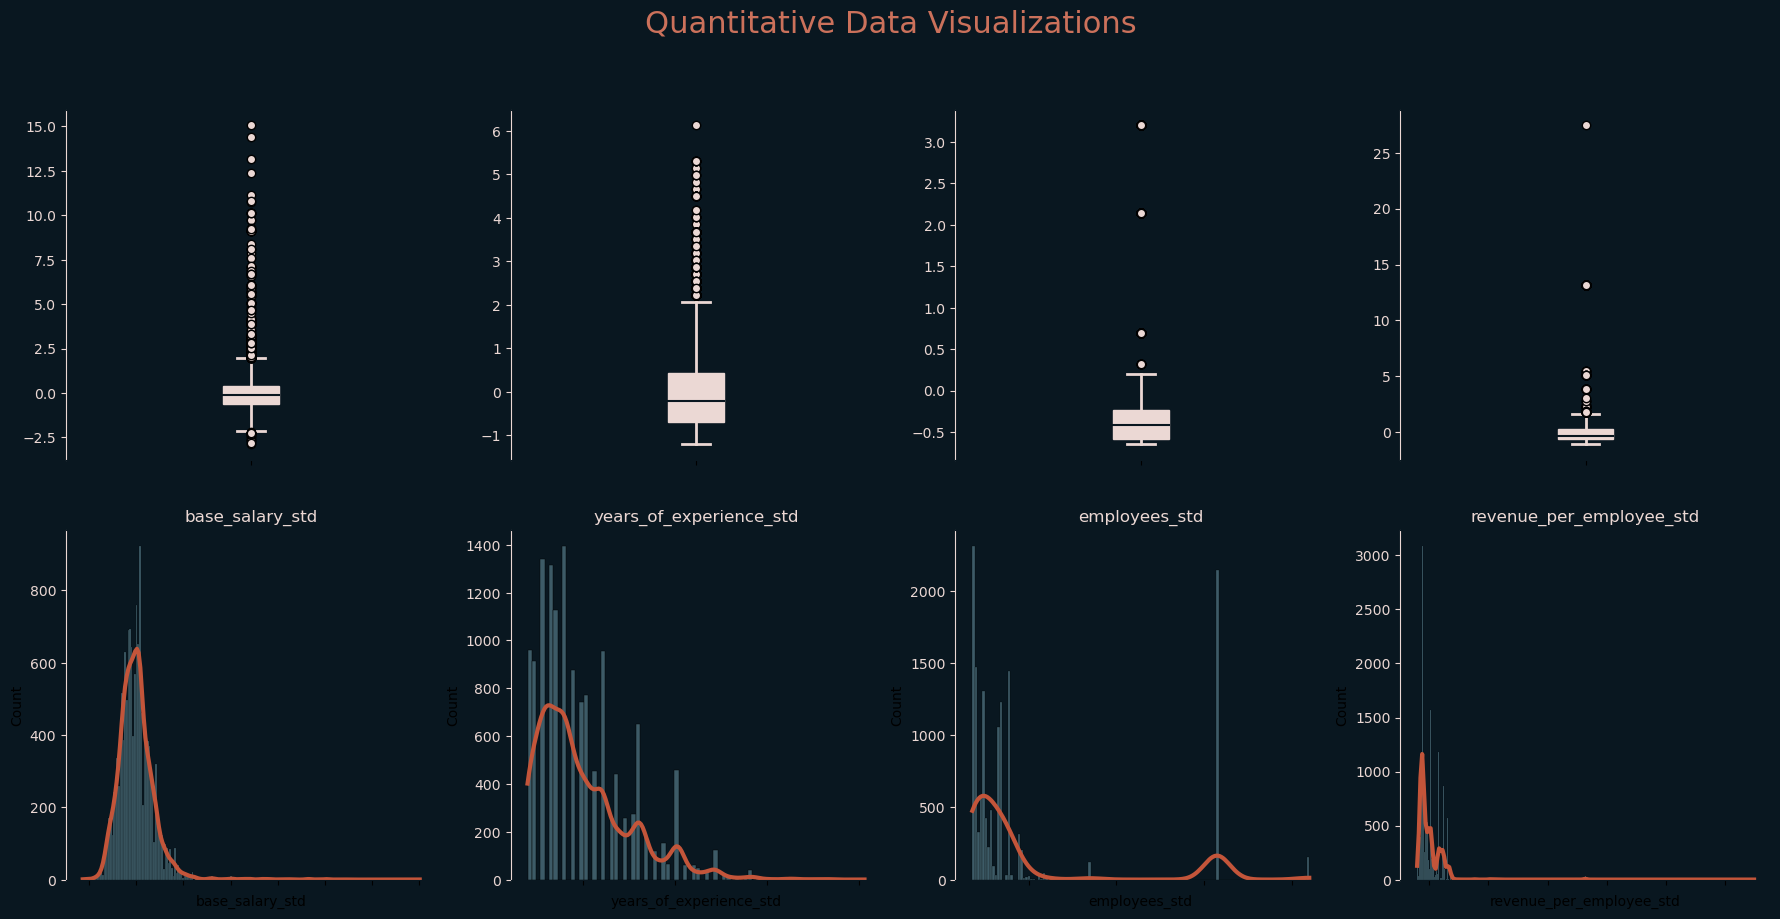

In [29]:
# plot predictions and targets versus original features    
fig,ax=plt.subplots(nrows=2, ncols=4, figsize=(22, 10)); fig.patch.set_facecolor('#091720')
fig.suptitle('Quantitative Data Visualizations', color='#CB715B', fontsize=22)

columns = ['base_salary_std', 'years_of_experience_std', 'employees_std', 'revenue_per_employee_std']

for i in range(4):
    public_companies.boxplot(column=columns[i], patch_artist = True, boxprops = dict(facecolor = "#EBD8D4", color='#EBD8D4'), medianprops = dict(color = "#091720", linewidth = 1.5),
                             whiskerprops = dict(color = "#EBD8D4", linewidth = 2), capprops = dict(color = "#EBD8D4", linewidth = 2), flierprops = dict(marker = 'o', markerfacecolor = "#EBD8D4"), ax=ax[0,i])
    ax[0,i].spines['bottom'].set_color('#091720'); ax[0,i].spines['top'].set_color('#091720'); ax[0,i].spines['right'].set_color('#091720')
    ax[0,i].spines['left'].set_color('#EBD8D4'); ax[0,i].set_facecolor('#091720')
    ax[0,i].tick_params(axis='y', colors='#EBD8D4'); ax[0,i].grid(visible=False); ax[0,i].set_xticklabels([])

for i in range(4):
    sns.histplot(public_companies[columns[i]], kde=True, color='#71A0AE', ax=ax[1, i])
    ax[1,i].set_title(columns[i], color='#EBD8D4')
    ax[1,i].spines['bottom'].set_color('#091720'); ax[1,i].spines['top'].set_color('#091720'); ax[1,i].spines['right'].set_color('#091720')
    ax[1,i].spines['left'].set_color('#EBD8D4'); ax[1,i].set_facecolor('#091720')
    ax[1,i].tick_params(axis='y', colors='#EBD8D4'); ax[1,i].grid(visible=False); ax[1,i].set_xticklabels([])
    ax[1,i].get_lines()[0].set_color('#C3553A'); ax[1,i].get_lines()[0].set_linewidth(3)


plt.show()

plt.show()

In [30]:
# drop nulls in employees and revenue per employee columns
public_companies.dropna(subset=['employees_std', 'revenue_per_employee_std'], inplace=True)
# remove outliers
public_companies = removeOutliersIQR(public_companies, 'base_salary_std')
public_companies = removeOutliersIQR(public_companies, 'years_of_experience_std')
public_companies = removeOutliersIQR(public_companies, 'employees_std')
public_companies = removeOutliersIQR(public_companies, 'revenue_per_employee_std')

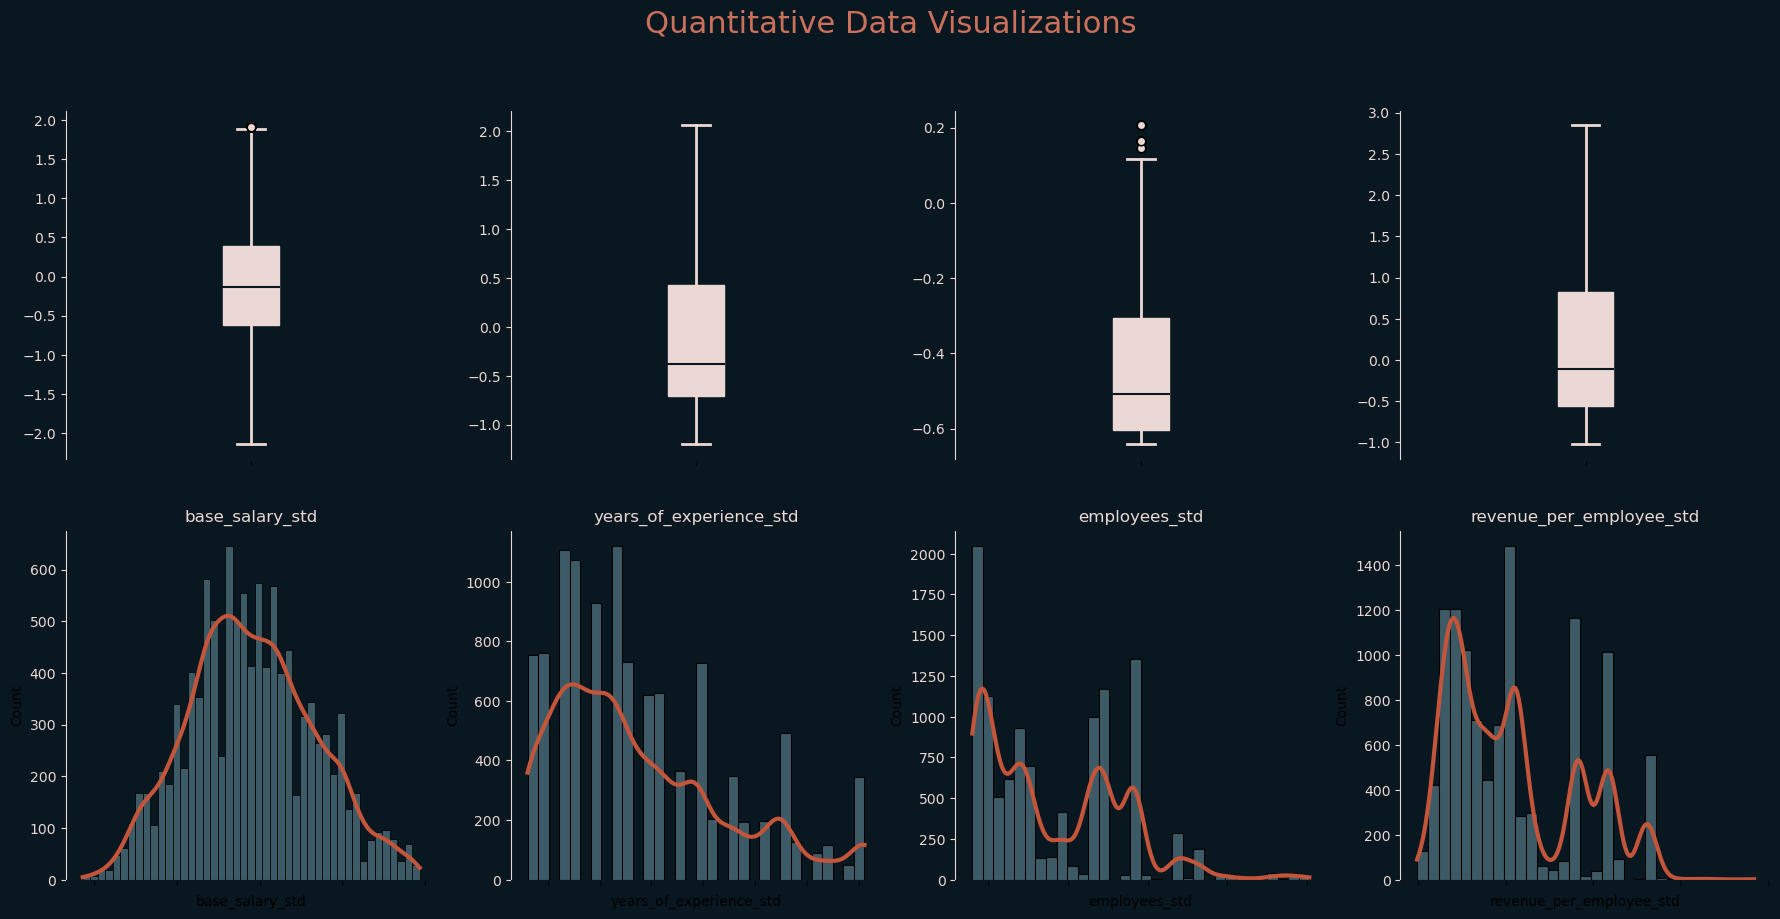

In [31]:
# plot predictions and targets versus original features    
fig,ax=plt.subplots(nrows=2, ncols=4, figsize=(22, 10)); fig.patch.set_facecolor('#091720')
fig.suptitle('Quantitative Data Visualizations', color='#CB715B', fontsize=22)

columns = ['base_salary_std', 'years_of_experience_std', 'employees_std', 'revenue_per_employee_std']

for i in range(4):
    public_companies.boxplot(column=columns[i], patch_artist = True, boxprops = dict(facecolor = "#EBD8D4", color='#EBD8D4'), medianprops = dict(color = "#091720", linewidth = 1.5),
                             whiskerprops = dict(color = "#EBD8D4", linewidth = 2), capprops = dict(color = "#EBD8D4", linewidth = 2), flierprops = dict(marker = 'o', markerfacecolor = "#EBD8D4"), ax=ax[0,i])
    ax[0,i].spines['bottom'].set_color('#091720'); ax[0,i].spines['top'].set_color('#091720'); ax[0,i].spines['right'].set_color('#091720')
    ax[0,i].spines['left'].set_color('#EBD8D4'); ax[0,i].set_facecolor('#091720')
    ax[0,i].tick_params(axis='y', colors='#EBD8D4'); ax[0,i].grid(visible=False); ax[0,i].set_xticklabels([])

for i in range(4):
    sns.histplot(public_companies[columns[i]], kde=True, color='#71A0AE', ax=ax[1, i])
    ax[1,i].set_title(columns[i], color='#EBD8D4')
    ax[1,i].spines['bottom'].set_color('#091720'); ax[1,i].spines['top'].set_color('#091720'); ax[1,i].spines['right'].set_color('#091720')
    ax[1,i].spines['left'].set_color('#EBD8D4'); ax[1,i].set_facecolor('#091720')
    ax[1,i].tick_params(axis='y', colors='#EBD8D4'); ax[1,i].grid(visible=False); ax[1,i].set_xticklabels([])
    ax[1,i].get_lines()[0].set_color('#C3553A'); ax[1,i].get_lines()[0].set_linewidth(3)


plt.show()

plt.show()

In [32]:
public_companies[['base_salary_std', 'years_of_experience_std', 'employees_std', 'revenue_per_employee_std']].describe()

,base_salary_std,years_of_experience_std,employees_std,revenue_per_employee_std
count,10961.000000,10961.000000,10961.000000,10961.000000
mean,-0.096881,-0.123951,-0.440944,0.072302
std,0.764534,0.833574,0.171683,0.720021
min,-2.140865,-1.196031,-0.640276,-1.014665
25%,-0.620248,-0.707955,-0.603348,-0.554174
50%,-0.133650,-0.382571,-0.507675,-0.112617
75%,0.393497,0.430888,-0.307317,0.830102
max,1.934389,2.057806,0.205400,2.843103


# Categorical Data
## Visualization

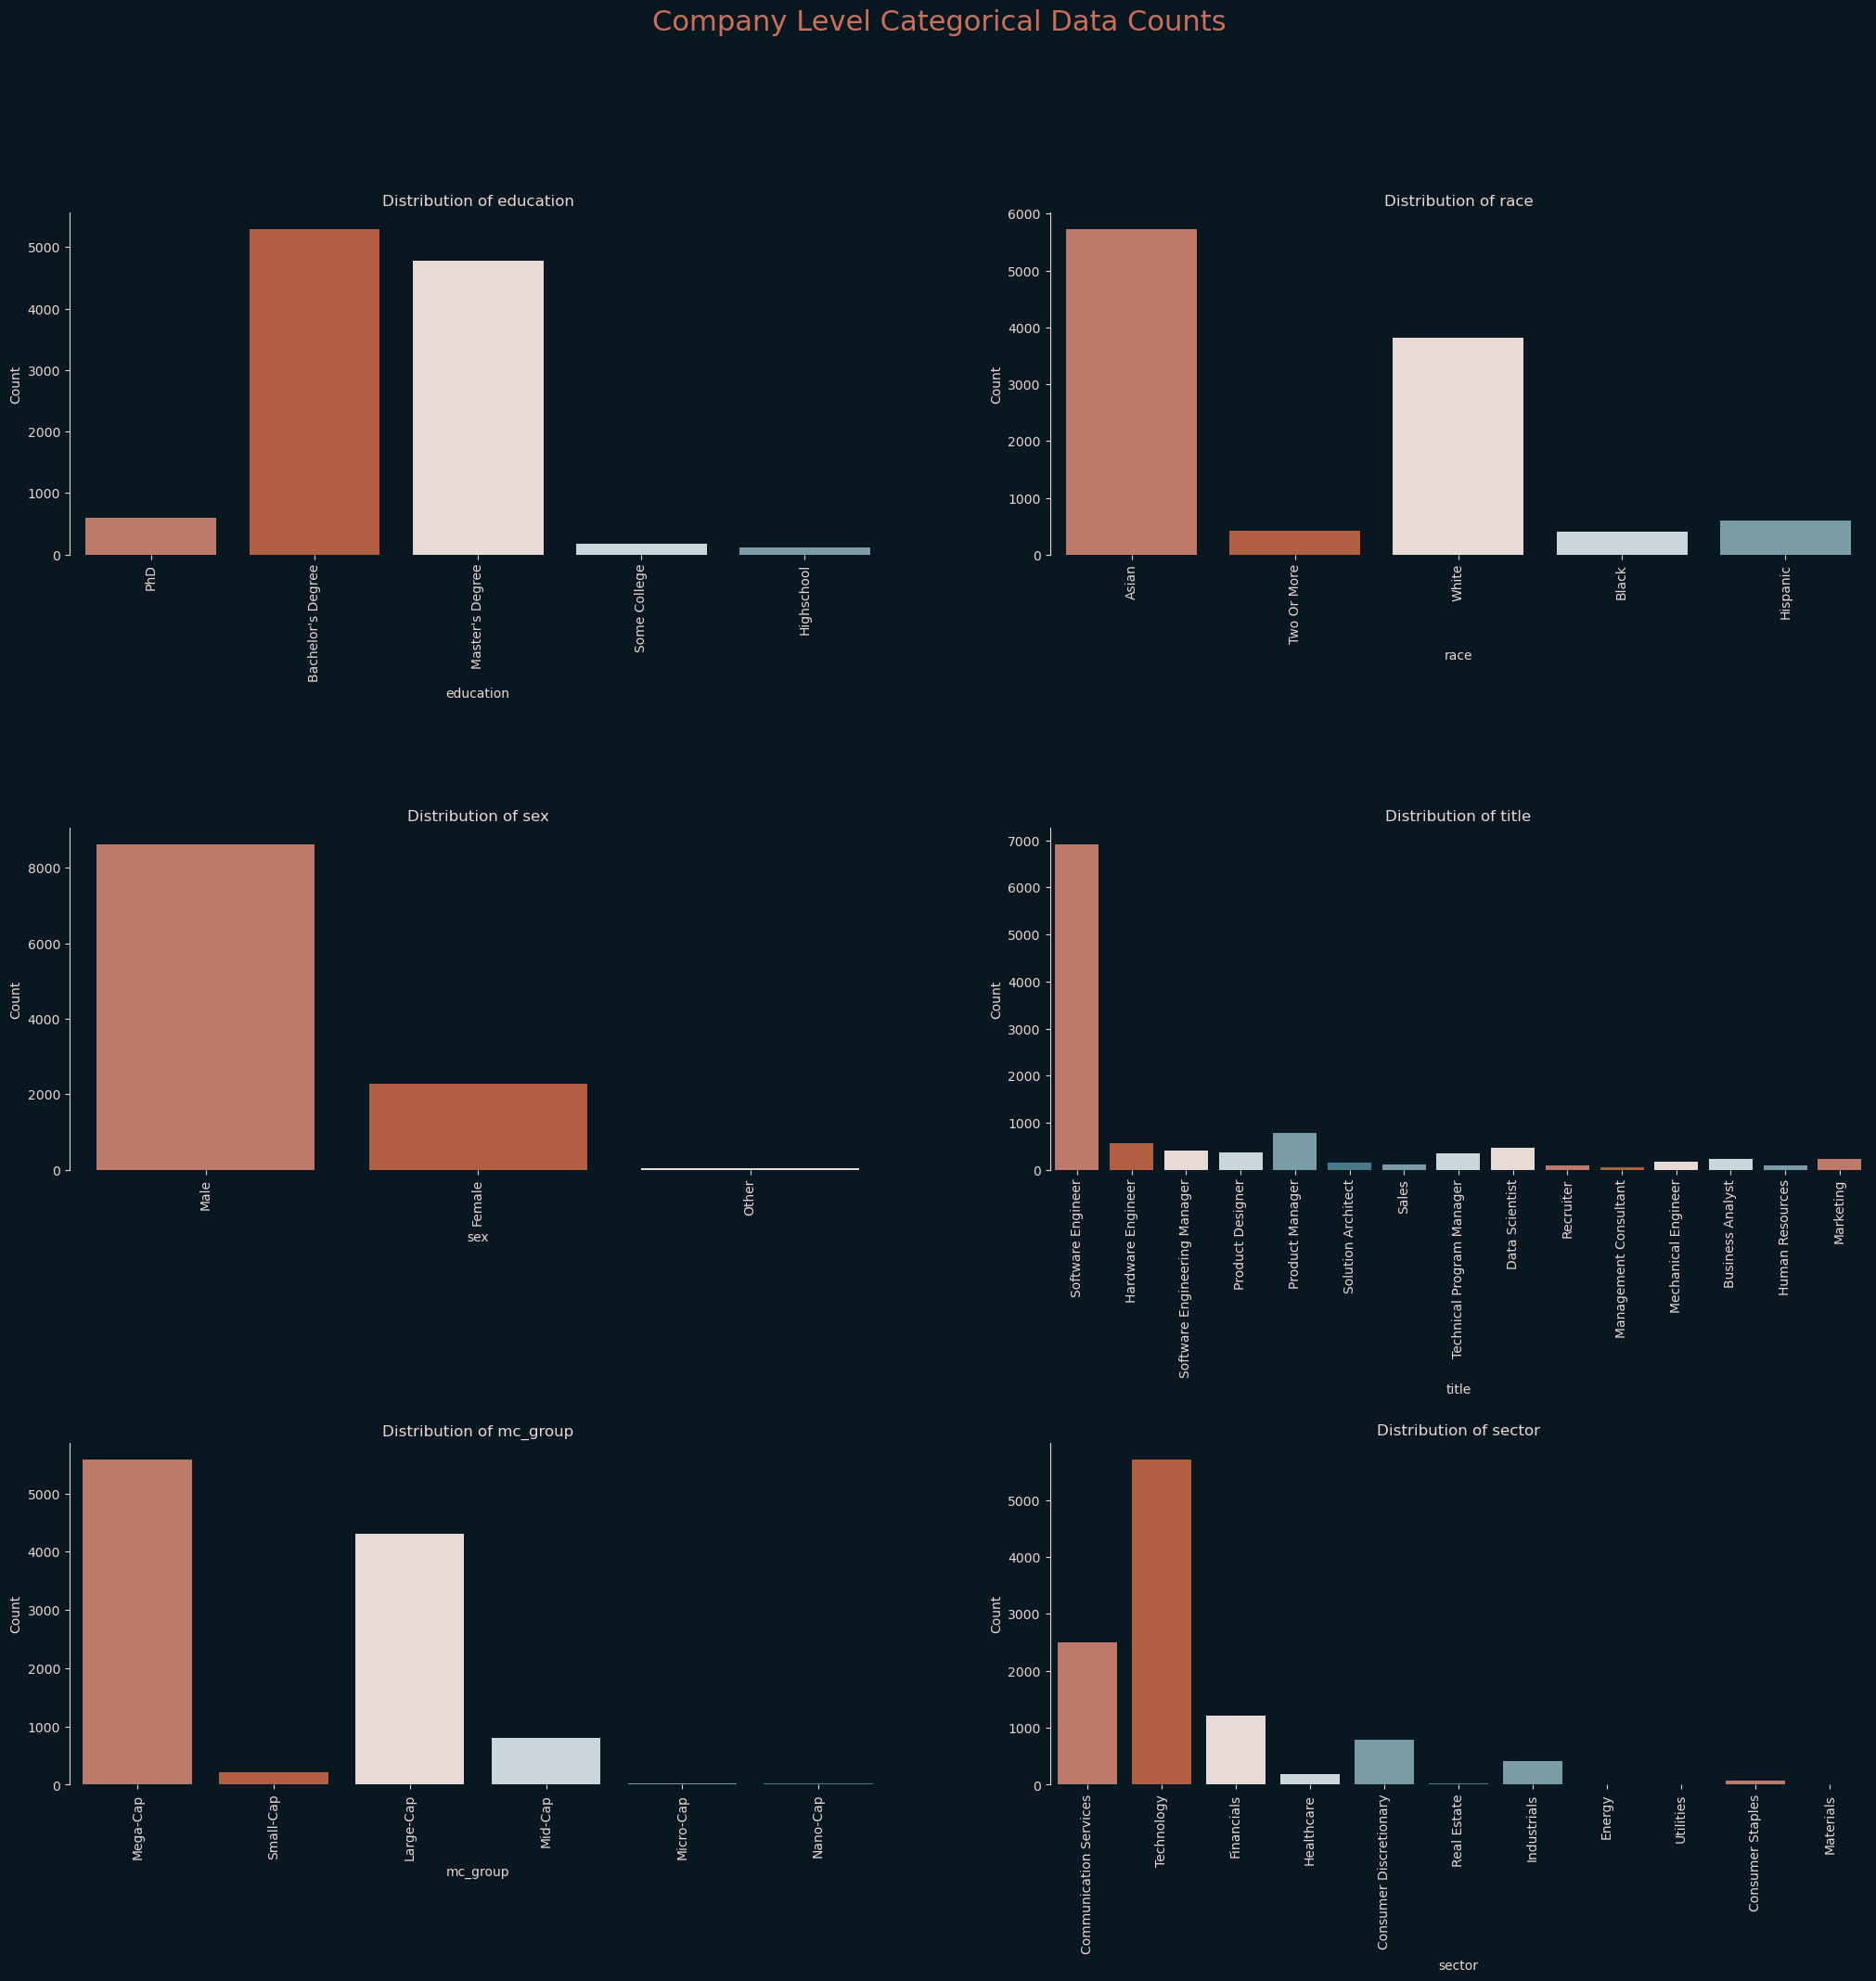

In [33]:
# Set color palette for countplots
palette = ['#CB715B', '#C35531', '#EBD8D4', '#C8D8DE', '#71A0AE', '#3F7F93', '#71A0AE', '#C8D8DE', '#EBD8D4', '#CB715B', '#C35531', '#EBD8D4', '#C8D8DE', '#71A0AE']

# plot distruibution of categorical variables    
fig,ax=plt.subplots(nrows=3, ncols=2); fig.set_figheight(22); fig.set_figwidth(25); fig.patch.set_facecolor('#091720')
fig.suptitle('Company Level Categorical Data Counts', color='#CB715B', fontsize=22)

columns = [['education', 'race'], ['sex', 'title'], ['mc_group', 'sector']]

for i in range(3):
    for j in range(2):
        sns.countplot(x=columns[i][j], data=public_companies, ax=ax[i, j], palette=palette)
        ax[i, j].set_title('Distribution of ' + columns[i][j], color='#EBD8D4')
        ax[i, j].set_ylabel('Count', color='#EBD8D4')
        ax[i, j].set_xlabel(columns[i][j], color='#EBD8D4')
        ax[i, j].set_facecolor('#091720')
        ax[i, j].tick_params(axis='y', colors='#EBD8D4')
        ax[i, j].tick_params(axis='x', colors='#EBD8D4')


        ax[i, j].spines['top'].set_visible(False)
        ax[i, j].spines['bottom'].set_visible(False)
        ax[i, j].spines['right'].set_visible(False)
        ax[i, j].spines['left'].set_color('#EBD8D4')
        ax[i, j].set_xticklabels(ax[i, j].get_xticklabels(), rotation=90)
        
plt.subplots_adjust(hspace=.8)

plt.show()

# Reducing Skew

## Checking Low Representation in Categories

In [34]:
public_companies[['education', 'race', 'sex', 'title', 'mc_group', 'sector']].describe()

,education,race,sex,title,mc_group,sector
count,10961,10961,10961,10961,10961,10961
unique,5,5,3,15,6,11
top,Bachelor's Degree,Asian,Male,Software Engineer,Mega-Cap,Technology
freq,5293,5728,8625,6918,5587,5714


In [35]:
mc_group_counts = public_companies.groupby('mc_group')['base_salary_std'].count()
sector_counts = public_companies.groupby('sector')['base_salary_std'].count()
mc_group_counts = pd.concat([mc_group_counts, sector_counts], axis=0)
print(mc_group_counts)

Large-Cap                 4306
Mega-Cap                  5587
Micro-Cap                   27
Mid-Cap                    802
Nano-Cap                    22
Small-Cap                  217
Communication Services    2508
Consumer Discretionary     790
Consumer Staples            79
Energy                       8
Financials                1219
Healthcare                 185
Industrials                415
Materials                    5
Real Estate                 32
Technology                5714
Utilities                    6
Name: base_salary_std, dtype: int64


In [36]:
# removing data entries belonging to categorwith less than 30 observations
public_companies = public_companies.drop(public_companies[public_companies['mc_group'] == 'Micro-Cap'].index)
public_companies = public_companies.drop(public_companies[public_companies['mc_group'] == 'Nano-Cap'].index)

public_companies = public_companies.drop(public_companies[public_companies['sector'] == 'Energy'].index)
public_companies = public_companies.drop(public_companies[public_companies['sector'] == 'Materials'].index)
public_companies = public_companies.drop(public_companies[public_companies['sector'] == 'Utilities'].index)

## Individual Level Data

In [37]:
# removing entries with 'other' as value in sex column
public_companies = public_companies[public_companies['sex'] != 'Other']

# Aggregating education levels into 2 categories
education = {"Highschool": "bachelors_max", "Some College": "bachelors_max", "Bachelor's Degree": "bachelors_max", "Master's Degree": "masters_min", "PhD": "masters_min"}
race = {"Black": "other", "Hispanic": "other", "Two Or More": "other"}
title = {"Management Consultant": "other", "Recruiter": "other", "Human Resources": "other", 'Sales': 'other', 'Solution Architect': 'other'}

# Replace values
public_companies['education'] = public_companies['education'].replace(education)
public_companies['race'] = public_companies['race'].replace(race)
public_companies['title'] = public_companies['title'].replace(title)

# creating a sample of overrepresented software engineer category
titles = public_companies[public_companies['title'] == 'Software Engineer']
titles = titles.sample(400, random_state = 42)
#removing all entries with software engineer as title value
public_companies = public_companies[public_companies['title'] != 'Software Engineer']
# adding sampled software engineer entries back into dataset
public_companies = pd.concat([public_companies, titles], ignore_index=True)

## Company Level Data

In [38]:
public_companies.groupby('sector')['base_salary_std'].count()

sector
Communication Services     982
Consumer Discretionary     314
Consumer Staples            23
Financials                 407
Healthcare                  77
Industrials                182
Real Estate                  6
Technology                2408
Name: base_salary_std, dtype: int64

In [39]:
# removing real estate and consumer staples categories from dataset because of low representation
public_companies = public_companies[(public_companies['sector'] != 'Real Estate') & (public_companies['sector'] != 'Consumer Staples')]

#aggregating values with low representation in the sector category
sector = {"Healthcare": "other", "Consumer Discretionary": "other", "Financials": "other", "Industrials": "other"}
mc_group = {"Large-Cap": "large_cap_max", "Mid-Cap": "large_cap_max", "Small-Cap": "large_cap_max",}

# Replace values
public_companies['sector'] = public_companies['sector'].replace(sector)
public_companies['mc_group'] = public_companies['mc_group'].replace(mc_group)

# sampling overrepresented technology value in sector category
sector = public_companies[public_companies['sector'] == 'Technology']
sector = sector.sample(1000, random_state = 42)

# removing technology from sector category in dataset
public_companies = public_companies[public_companies['sector'] != 'Technology']
# adding sampled set of technology sectors to dataset
public_companies = pd.concat([public_companies, sector], ignore_index=True)

# Final Visualizations of Categorical Data

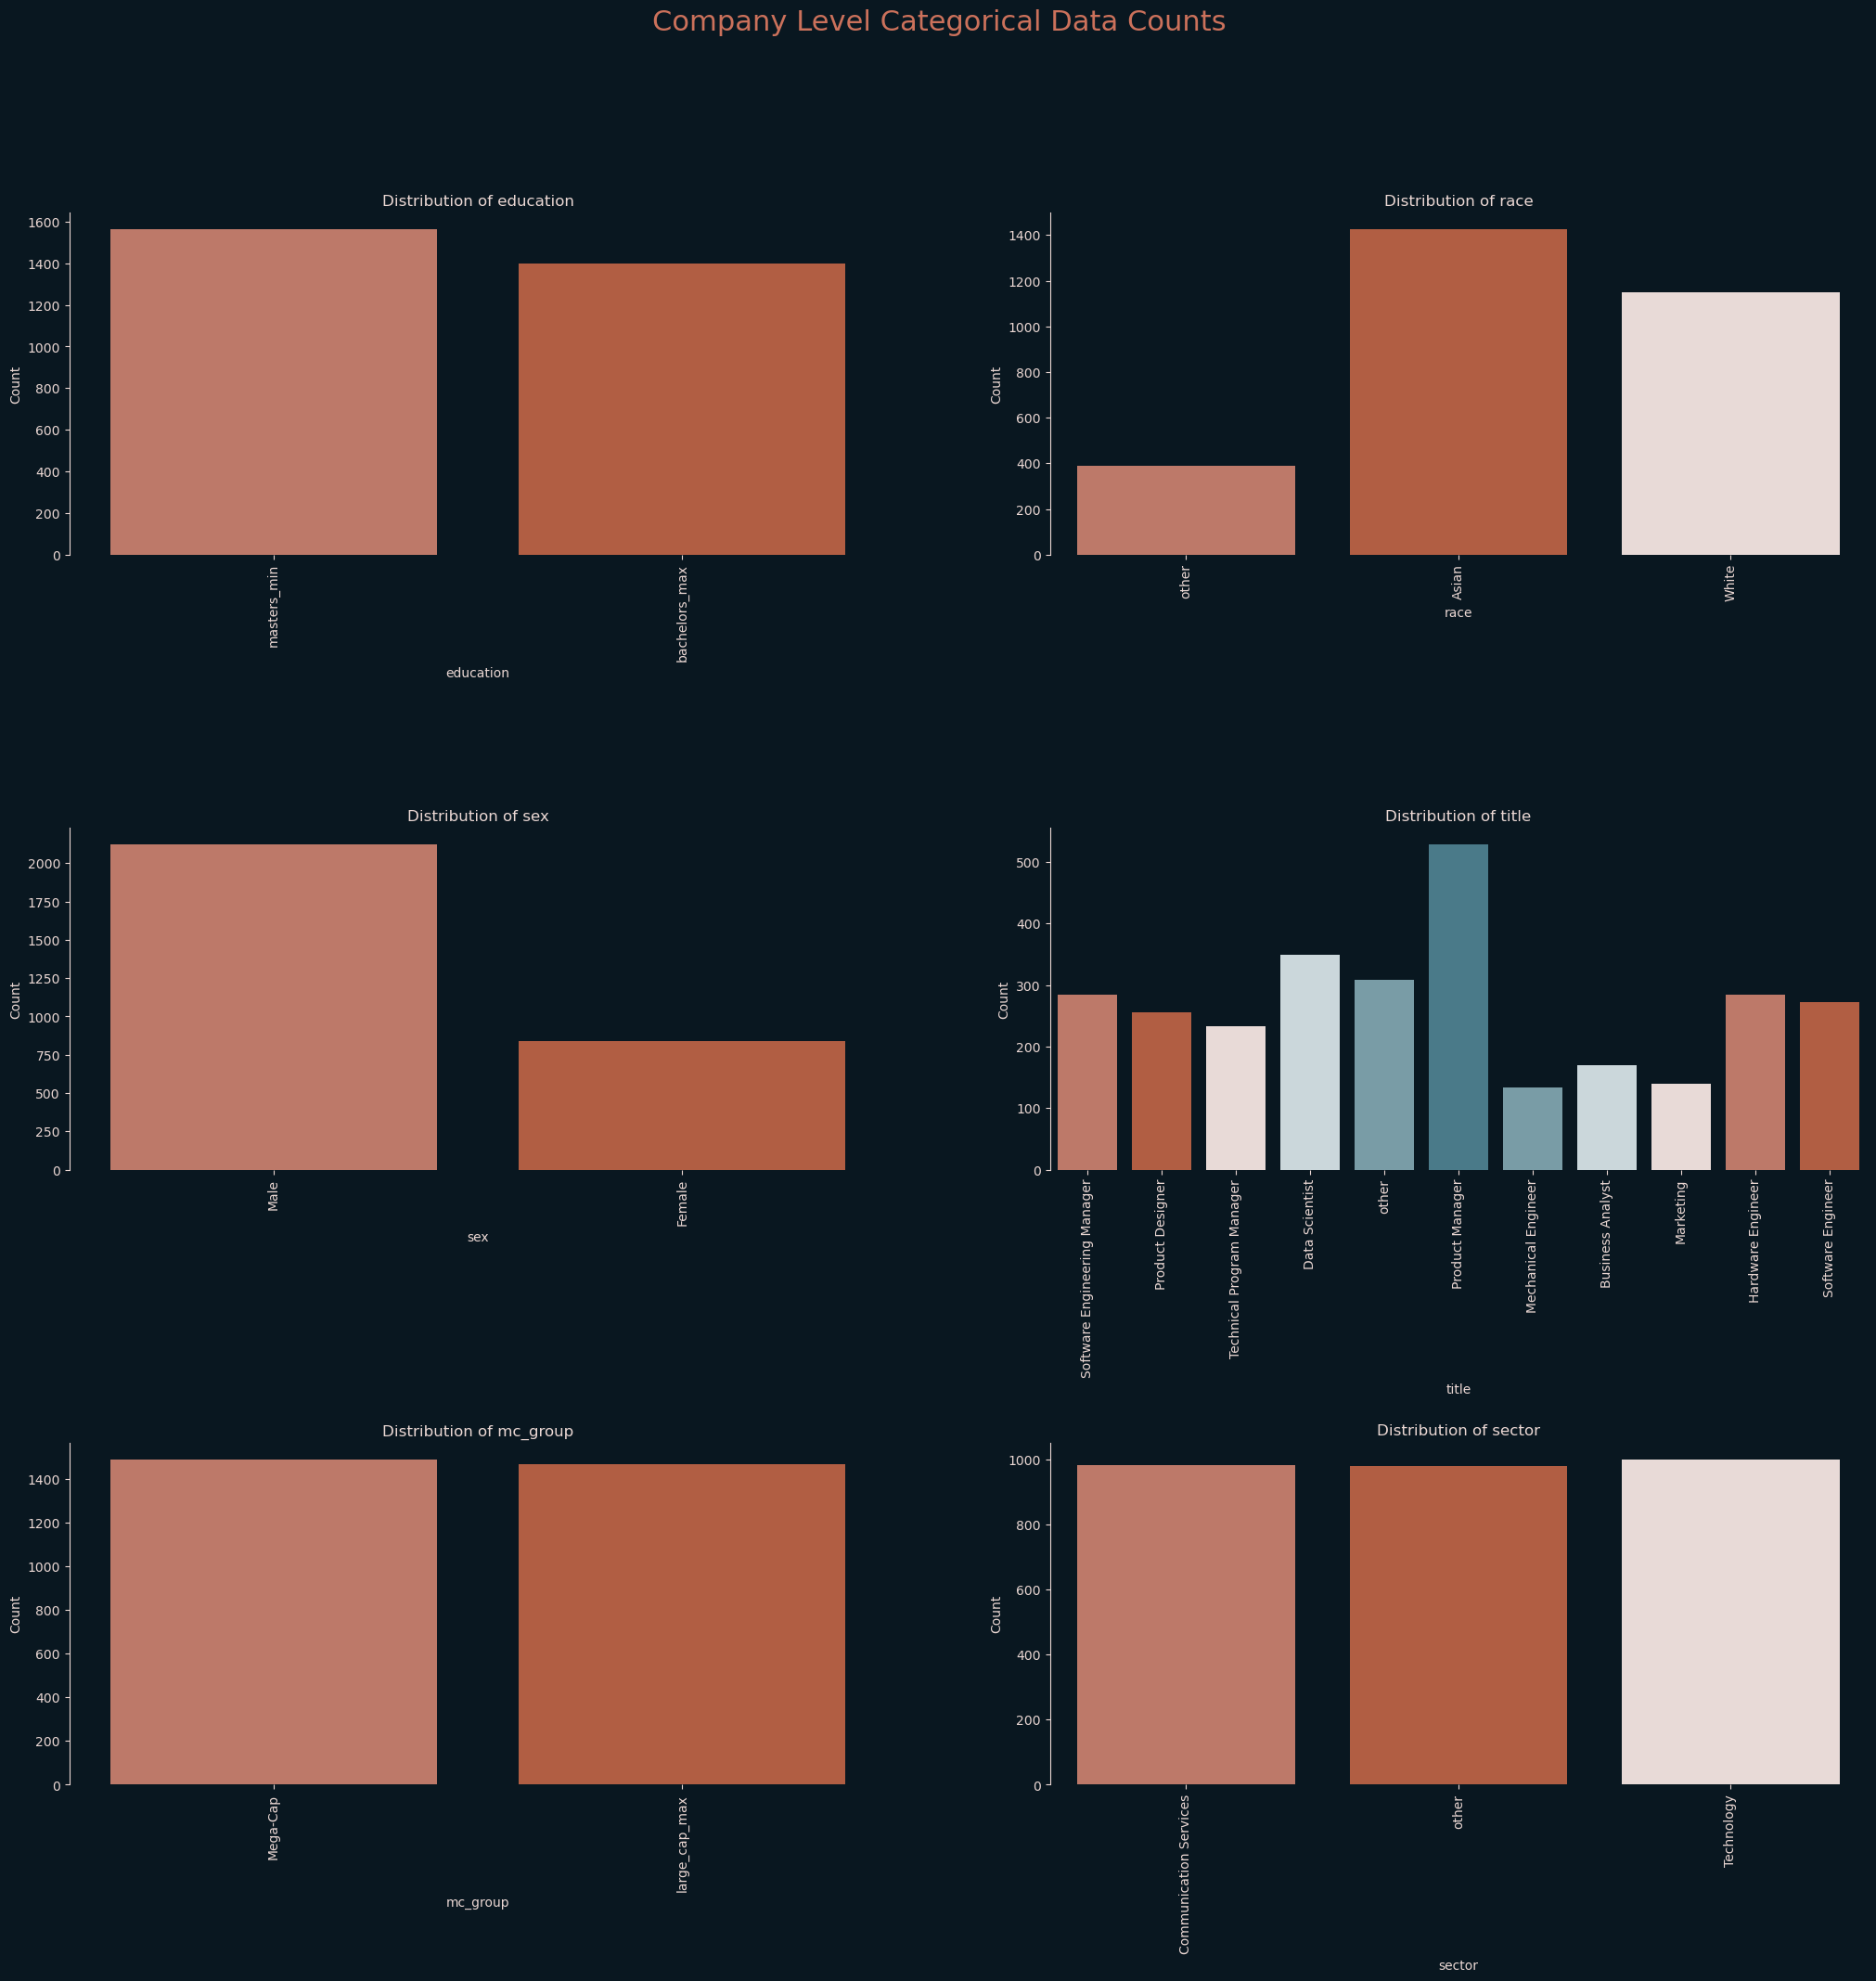

In [40]:
# plot predictions and targets versus original features    
fig,ax=plt.subplots(nrows=3, ncols=2); fig.set_figheight(22); fig.set_figwidth(25); fig.patch.set_facecolor('#091720')
fig.suptitle('Company Level Categorical Data Counts', color='#CB715B', fontsize=22)

columns = [['education', 'race'], ['sex', 'title'], ['mc_group', 'sector']]

for i in range(3):
    for j in range(2):
        sns.countplot(x=columns[i][j], data=public_companies, ax=ax[i, j], palette=palette)
        ax[i, j].set_title('Distribution of ' + columns[i][j], color='#EBD8D4')
        ax[i, j].set_ylabel('Count', color='#EBD8D4')
        ax[i, j].set_xlabel(columns[i][j], color='#EBD8D4')
        ax[i, j].set_facecolor('#091720')
        ax[i, j].tick_params(axis='y', colors='#EBD8D4')
        ax[i, j].tick_params(axis='x', colors='#EBD8D4')


        ax[i, j].spines['top'].set_visible(False)
        ax[i, j].spines['bottom'].set_visible(False)
        ax[i, j].spines['right'].set_visible(False)
        ax[i, j].spines['left'].set_color('#EBD8D4')
        ax[i, j].set_xticklabels(ax[i, j].get_xticklabels(), rotation=90)
        
plt.subplots_adjust(hspace=.8)

plt.show()

# Categorical Data Encoding

In [41]:
# encoding nominal categories
x=['title', 'race', 'sex', 'sector']
public_companies = pd.get_dummies(public_companies, columns=['title', 'race', 'sex', 'sector'], prefix=x, drop_first=True, dtype=int)

public_companies.loc[:, 'title_Data Scientist':'sector_Technology'].sample(3)

,title_Data Scientist,title_Hardware Engineer,title_Marketing,title_Mechanical Engineer,title_Product Designer,title_Product Manager,title_Software Engineer,title_Software Engineering Manager,title_Technical Program Manager,title_other,race_White,race_other,sex_Male,sector_Technology
128,0,0,0,0,0,0,0,1,0,0,0,1,1,0
1543,0,0,0,0,0,1,0,0,0,0,0,1,1,0
2848,0,1,0,0,0,0,0,0,0,0,0,0,1,1


In [42]:
# Encoding Ordinal categories
education_dict = {'masters_min': 1, 'bachelors_max': 0}
mc_group_dict = {'large_cap_max': 0, 'Mega-Cap': 1}

# Change values to correspond with dict values
public_companies['education_encoded'] = public_companies['education'].map(education_dict)
public_companies['mc_group_encoded'] = public_companies['mc_group'].map(mc_group_dict)

public_companies[['education', 'education_encoded', 'mc_group', 'mc_group_encoded']].sample(5)

,education,education_encoded,mc_group,mc_group_encoded
2848,masters_min,1,Mega-Cap,1
1257,masters_min,1,large_cap_max,0
309,masters_min,1,Mega-Cap,1
775,masters_min,1,Mega-Cap,1
1909,bachelors_max,0,large_cap_max,0


# Correlation Analysis

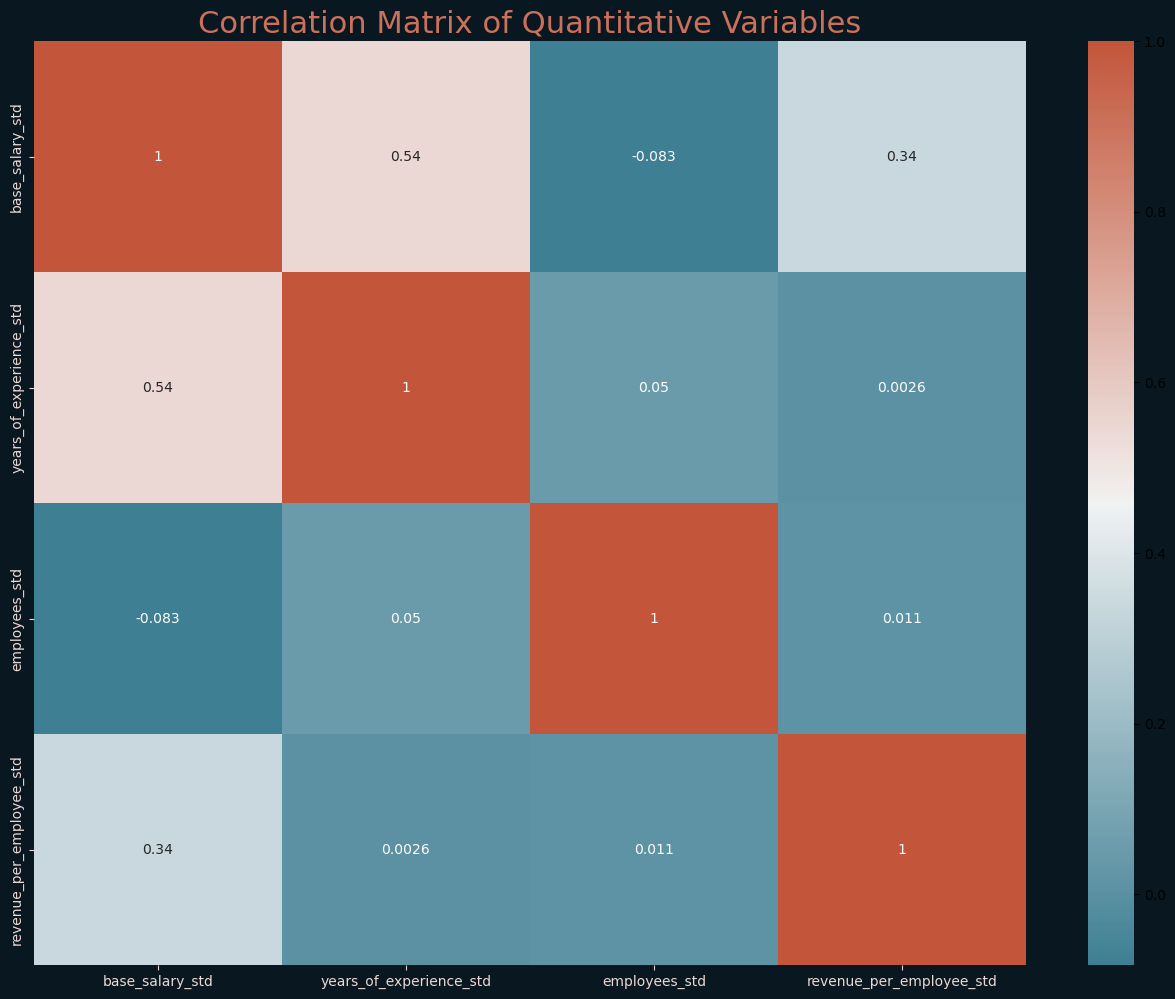

In [43]:
public_companies_cleaned = public_companies[['base_salary_std', 'years_of_experience_std',
                                             'employees_std', 'revenue_per_employee_std']]

corr_matrix = public_companies_cleaned.corr()

# Visualize correlation matrix)
plt.figure(figsize=(16, 12), facecolor='#091720')

sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

plt.tick_params(colors='#EBD8D4')
plt.title('Correlation Matrix of Quantitative Variables', color='#CB715B', fontsize=22)
plt.show()

plt.show()

![multiple](images/multiple.png) 

# Split Dataset

In [44]:
# dropping dependent variable and nonstandardized variables
X = public_companies.drop(['base_salary_std', 'base_salary', 'years_of_experience', 'employees', 'revenue_per_employee', 'education', 'mc_group'], axis=1)

# dependent variable
y = public_companies['base_salary_std']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add constant
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

## Cross Validation Function

In [45]:
def crossValidationLR(X, y, folds=5, random_state=42, constant=True):
    from statsmodels.stats.stattools import durbin_watson
    from datetime import datetime
    
    # get date and time
    date = datetime.now()
    day = date.strftime("%a, %d %b %Y")
    time = date.strftime('%H:%M:%S')

    # list to store params and metrics of each model
    model_params = []
    r_squared = []
    adj_r_squared =[]
    f_stat = []
    f_p_value = []
    durb_wat = []
    
    # Create list for storing p-values
    if constant:
        p_values = [[] for x in range(X.shape[1] + 1)]
    else:
        p_values = [[] for x in range(X.shape[1])]
    
    # Initialize the cross-validator, set folds to 5 or number passed
    kf = KFold(n_splits=folds, random_state=random_state, shuffle=True)
    
    # saving column names for reference because they are dropped in conversion
    columns = X.columns
    
    # Convert to numpy array
    X = X.to_numpy()

    # Model each fold
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if constant:
            # Add Constants
            X_train = sm.add_constant(X_train)
            X_test = sm.add_constant(X_test)

        # Train model
        lm = sm.OLS(y_train, X_train).fit()
        
        # Save params and metrics for averaging
        model_params.append(lm.params)
        r_squared.append(lm.rsquared)
        adj_r_squared.append(lm.rsquared_adj)
        f_stat.append(lm.fvalue)
        f_p_value.append(lm.f_pvalue)
        durb_wat.append(durbin_watson(lm.resid))
            

        for x in range(len(lm.params)):
            p_values[x].append(lm.pvalues[x])
        
        # Save p-values of variables
        for x in range(len(lm.params)): p_values[x].append(lm.pvalues[x])
    
    # Save Statistic Means and stds
    r_squared_mean = np.mean(r_squared)
    r_squared_std = np.std(r_squared)

    adj_r_squared_mean = np.mean(adj_r_squared)
    adj_r_squared_std = np.std(adj_r_squared)

    f_stat_mean = np.mean(f_stat)
    f_stat_std = np.std(f_stat)

    f_p_value_mean = np.mean(f_p_value)
    f_p_value_std = np.std(f_p_value)
    
    p_values_means = [np.mean(values) for values in p_values]
    
    durb_wat_mean = np.mean(durb_wat)
    durb_wat_std = np.std(durb_wat)
    
    # Calculate params from averaging all models params
    params_final = np.mean(model_params, axis=0)
    # Calculate standard deviation of params
    params_std = np.std(model_params, axis=0)

    # Print the formatted information with right alignment
    print(f'{"OLS Cross-Validation Averaging":^62}')
    print('================================================================')
    print(f'{"Num Folds:"} {folds:>53}')
    print(f'{"Dep. Variable:"} {y.name:>49}')
    print(f'{"Model:"} {"OLS":>57}')
    print(f'{"Method:"} {"Least Squares":>56}')
    print(f'{"Date:"} {day:>58}')
    print(f'{"Time:"} {time:>58}')
    print('================================================================')
    
    # Print Statistic Means
    print(f'{"mean":>53}  {"std":>9}')
    print('----------------------------------------------------------------')
    print(f'{"R-squared":>35} {r_squared_mean:>17.3f} {r_squared_std:>10.3f}')
    print(f'{"Adj. R-squared":>35} {adj_r_squared_mean:>17.3f} {adj_r_squared_std:>10.3f}')
    print(f'{"F-statistic":>35} {f_stat_mean:>17.3f} {f_stat_std:>10.3f}')
    print(f'{"Prob (F-statistic)":>35} {f_p_value_mean:>17.3f} {f_p_value_std:>10.3f}')
    print(f"{'Durbin-Watson':>35} {durb_wat_mean:>17.3f} {durb_wat_std:>10.3f}")

    if constant:
    # Print Coefficients and P-values with constant
        print('================================================================')
        print(f'{"coef":>46} {"std":>6} {"P>|t|":>10}')
        print('----------------------------------------------------------------')
        print(f'{"const":>35} {params_final[0]:>10,.3f} {params_std[0]:>6.3f} {p_values_means[0]:>10,.3f}')
        for x in range(0, len(columns)):
            print(f'{columns[x]:>35} {params_final[x+1]:>10.3f} {params_std[x+1]:>6.3f} {p_values_means[x]:>10.3f}')
        print('\n================================================================\n')
    
    else:
         # Print Coefficients and P-values without constant
        print('================================================================')
        print(f'{"coef":>46}  {"P>|t|":>9}')
        print('----------------------------------------------------------------')
        for x in range(0, len(columns)):
            print(f'{columns[x]:>35} {params_final[x]:>6.3f} {params_std[x]:>6.3f} {p_values_means[x]:>10.3f}')
        print('\n================================================================\n')
    ''' Create Model using cross validation params'''

    # Train/Test Split of all data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    # Add constant
    if constant:
        X_train = sm.add_constant(X_train)
    # Initialize new model 
    lm = sm.OLS(y_train, X_train).fit()
    
    # Update the model parameters with the average coefficients
    lm.params = params_final
    # Update lm attributes to be able to acces durbin watson without returning it
    lm.durb_wat_mean = durb_wat_mean
    
    return lm

# Multivariate Linear Regression Modeling

## Analyze Removal of Quantitative Variables

Our goal is to evaluate quantitative variables based on p-value.  Those with a p-value over .05 will be eliminated from the model.  This will be done one by one with the maximum p-value being removed on each iteration.

In [46]:
lm  = crossValidationLR(X, y)

                OLS Cross-Validation Averaging                
Num Folds:                                                     5
Dep. Variable:                                   base_salary_std
Model:                                                       OLS
Method:                                            Least Squares
Date:                                           Tue, 23 Apr 2024
Time:                                                   16:17:43
                                                 mean        std
----------------------------------------------------------------
                          R-squared             0.557      0.012
                     Adj. R-squared             0.553      0.012
                        F-statistic           147.614      6.808
                 Prob (F-statistic)             0.000      0.000
                      Durbin-Watson             1.966      0.012
                                          coef    std      P>|t|
---------------------------

In [47]:
y_pred = lm.predict(X_test)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.3342802447523502
Linear Regression - MAE: 0.45030645089790006


# Analyze Removal of Categorical Variables

Here we will be test building a model without each of the categorical variables with replacement.  We expect the overall fit of the model to decrease with each variable removed, however those with little impact on the overall fit will be removed from the variables of interest to maximize the effect of the most significant variables.

## Test Removing Education

In [48]:
X_revised        =       X.drop(columns='education_encoded', inplace=False)
X_train_revised  = X_train.drop(columns='education_encoded', inplace=False)
X_test_revised   =  X_test.drop(columns='education_encoded', inplace=False)

lm  = crossValidationLR(X_revised, y)

                OLS Cross-Validation Averaging                
Num Folds:                                                     5
Dep. Variable:                                   base_salary_std
Model:                                                       OLS
Method:                                            Least Squares
Date:                                           Tue, 23 Apr 2024
Time:                                                   16:17:43
                                                 mean        std
----------------------------------------------------------------
                          R-squared             0.546      0.012
                     Adj. R-squared             0.543      0.012
                        F-statistic           149.068      7.215
                 Prob (F-statistic)             0.000      0.000
                      Durbin-Watson             1.965      0.011
                                          coef    std      P>|t|
---------------------------

In [49]:
y_pred = lm.predict(X_test_revised)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.34181137958146063
Linear Regression - MAE: 0.45801523984640524


# Test Removing Sex

In [50]:
X_revised        =       X.drop(columns='sex_Male', inplace=False)
X_train_revised  = X_train.drop(columns='sex_Male', inplace=False)
X_test_revised   =  X_test.drop(columns='sex_Male', inplace=False)

lm  = crossValidationLR(X_revised, y)

                OLS Cross-Validation Averaging                
Num Folds:                                                     5
Dep. Variable:                                   base_salary_std
Model:                                                       OLS
Method:                                            Least Squares
Date:                                           Tue, 23 Apr 2024
Time:                                                   16:17:43
                                                 mean        std
----------------------------------------------------------------
                          R-squared             0.555      0.011
                     Adj. R-squared             0.551      0.012
                        F-statistic           154.206      7.052
                 Prob (F-statistic)             0.000      0.000
                      Durbin-Watson             1.962      0.012
                                          coef    std      P>|t|
---------------------------

### Result
>Removing sex decreased r^2 and adjusted r^2 by .001.  We can conlude based on this that sex is not a significant variable to the model.

In [51]:
y_pred = lm.predict(X_test_revised)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.33339754268141875
Linear Regression - MAE: 0.44960766522106066


# Test Removing Race

In [52]:
X_revised        =       X.drop(columns=['race_White', 'race_other'], inplace=False)
X_train_revised  = X_train.drop(columns=['race_White', 'race_other'], inplace=False)
X_test_revised   =  X_test.drop(columns=['race_White', 'race_other'], inplace=False)

lm  = crossValidationLR(X_revised, y)

                OLS Cross-Validation Averaging                
Num Folds:                                                     5
Dep. Variable:                                   base_salary_std
Model:                                                       OLS
Method:                                            Least Squares
Date:                                           Tue, 23 Apr 2024
Time:                                                   16:17:43
                                                 mean        std
----------------------------------------------------------------
                          R-squared             0.556      0.012
                     Adj. R-squared             0.552      0.012
                        F-statistic           163.428      7.638
                 Prob (F-statistic)             0.000      0.000
                      Durbin-Watson             1.968      0.011
                                          coef    std      P>|t|
---------------------------

In [53]:
y_pred = lm.predict(X_test_revised)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.33472913161725837
Linear Regression - MAE: 0.45041705627960626


# Test Removing Sector

In [54]:
X_revised        =       X.drop(columns=['sector_Technology', 'sector_other'], inplace=False)
X_train_revised  = X_train.drop(columns=['sector_Technology', 'sector_other'], inplace=False)
X_test_revised   =  X_test.drop(columns=['sector_Technology', 'sector_other'], inplace=False)

lm  = crossValidationLR(X_revised, y)

                OLS Cross-Validation Averaging                
Num Folds:                                                     5
Dep. Variable:                                   base_salary_std
Model:                                                       OLS
Method:                                            Least Squares
Date:                                           Tue, 23 Apr 2024
Time:                                                   16:17:44
                                                 mean        std
----------------------------------------------------------------
                          R-squared             0.540      0.012
                     Adj. R-squared             0.537      0.012
                        F-statistic           153.587      7.211
                 Prob (F-statistic)             0.000      0.000
                      Durbin-Watson             1.971      0.014
                                          coef    std      P>|t|
---------------------------

In [55]:
y_pred = lm.predict(X_test_revised)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.3520557144059954
Linear Regression - MAE: 0.464440442847707


# Test Removing Market Cap Group

In [56]:
X_revised        =       X.drop(columns=['mc_group_encoded'], inplace=False)
X_train_revised  = X_train.drop(columns=['mc_group_encoded'], inplace=False)
X_test_revised   =  X_test.drop(columns=['mc_group_encoded'], inplace=False)

lm  = crossValidationLR(X_revised, y)

                OLS Cross-Validation Averaging                
Num Folds:                                                     5
Dep. Variable:                                   base_salary_std
Model:                                                       OLS
Method:                                            Least Squares
Date:                                           Tue, 23 Apr 2024
Time:                                                   16:17:44
                                                 mean        std
----------------------------------------------------------------
                          R-squared             0.553      0.012
                     Adj. R-squared             0.549      0.012
                        F-statistic           152.904      7.133
                 Prob (F-statistic)             0.000      0.000
                      Durbin-Watson             1.963      0.011
                                          coef    std      P>|t|
---------------------------

In [57]:
y_pred = lm.predict(X_test_revised)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.3384031272912047
Linear Regression - MAE: 0.4538401320700534


# Test Removing Title

In [58]:
X_revised        =       X.drop(columns=['title_Data Scientist',
                                         'title_Hardware Engineer',
                                         'title_Marketing',
                                         'title_Mechanical Engineer',	
                                         'title_Product Designer',	
                                         'title_Product Manager',	
                                         'title_Software Engineer',	
                                         'title_Software Engineering Manager',	
                                         'title_Technical Program Manager',
                                         'title_other'], inplace=False)
X_train_revised  = X_train.drop(columns=['title_Data Scientist',
                                         'title_Hardware Engineer',
                                         'title_Marketing',
                                         'title_Mechanical Engineer',	
                                         'title_Product Designer',	
                                         'title_Product Manager',	
                                         'title_Software Engineer',	
                                         'title_Software Engineering Manager',	
                                         'title_Technical Program Manager',
                                         'title_other'], inplace=False)
X_test_revised   =  X_test.drop(columns=['title_Data Scientist',
                                         'title_Hardware Engineer',
                                         'title_Marketing',
                                         'title_Mechanical Engineer',	
                                         'title_Product Designer',	
                                         'title_Product Manager',	
                                         'title_Software Engineer',	
                                         'title_Software Engineering Manager',	
                                         'title_Technical Program Manager',
                                         'title_other'], inplace=False)

lm  = crossValidationLR(X_revised, y)

                OLS Cross-Validation Averaging                
Num Folds:                                                     5
Dep. Variable:                                   base_salary_std
Model:                                                       OLS
Method:                                            Least Squares
Date:                                           Tue, 23 Apr 2024
Time:                                                   16:17:44
                                                 mean        std
----------------------------------------------------------------
                          R-squared             0.473      0.011
                     Adj. R-squared             0.471      0.011
                        F-statistic           212.085      8.855
                 Prob (F-statistic)             0.000      0.000
                      Durbin-Watson             1.938      0.008
                                          coef    std      P>|t|
---------------------------

In [59]:
y_pred = lm.predict(X_test_revised)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.3928355708888174
Linear Regression - MAE: 0.503157426999334


# Model with Original Dataset Variables Exclusively

> Here we want to analyze the difference between models calculated with the stock dataset and without to compare overall fit.

In [60]:
X_revised        =       X.drop( columns=['employees_std',
                                          'revenue_per_employee_std', 
                                          'mc_group_encoded',
                                          'sector_other',
                                          'sector_Technology'], inplace=False)
X_train_revised  = X_train.drop( columns=['employees_std',
                                          'revenue_per_employee_std', 
                                          'mc_group_encoded',
                                          'sector_other',
                                          'sector_Technology'], inplace=False)
X_test_revised   =  X_test.drop( columns=['employees_std',
                                          'revenue_per_employee_std', 
                                          'mc_group_encoded',
                                          'sector_other',
                                          'sector_Technology'], inplace=False)

lm1  = crossValidationLR(X_revised, y)

                OLS Cross-Validation Averaging                
Num Folds:                                                     5
Dep. Variable:                                   base_salary_std
Model:                                                       OLS
Method:                                            Least Squares
Date:                                           Tue, 23 Apr 2024
Time:                                                   16:17:44
                                                 mean        std
----------------------------------------------------------------
                          R-squared             0.411      0.014
                     Adj. R-squared             0.407      0.014
                        F-statistic           109.477      6.201
                 Prob (F-statistic)             0.000      0.000
                      Durbin-Watson             1.963      0.016
                                          coef    std      P>|t|
---------------------------

In [61]:
y_pred2 = lm1.predict(X_test_revised)
print("Linear Regression - MSE:",  mean_squared_error(y_test, y_pred2))
print("Linear Regression - MAE:", mean_absolute_error(y_test, y_pred2))

Linear Regression - MSE: 0.43340240934052526
Linear Regression - MAE: 0.5251991746769872


# Test Removing Combinations of Categorical Variables

In [62]:
X              =       X.drop(columns=['sex_Male', 
                                       'mc_group_encoded',
                                       'race_White',
                                       'race_other',
                                       'sector_Technology', 
                                       'sector_other'], inplace=False)
X_train_final  = X_train.drop(columns=['sex_Male', 
                                       'mc_group_encoded',
                                       'race_White',
                                       'race_other',
                                       'sector_Technology', 
                                       'sector_other'], inplace=False)
X_test_final   =  X_test.drop(columns=['sex_Male', 
                                       'mc_group_encoded',
                                       'race_White',
                                       'race_other',
                                       'sector_Technology', 
                                       'sector_other'], inplace=False)

lm  = crossValidationLR(X, y)

                OLS Cross-Validation Averaging                
Num Folds:                                                     5
Dep. Variable:                                   base_salary_std
Model:                                                       OLS
Method:                                            Least Squares
Date:                                           Tue, 23 Apr 2024
Time:                                                   16:17:44
                                                 mean        std
----------------------------------------------------------------
                          R-squared             0.528      0.012
                     Adj. R-squared             0.525      0.012
                        F-statistic           188.165      8.953
                 Prob (F-statistic)             0.000      0.000
                      Durbin-Watson             1.963      0.013
                                          coef    std      P>|t|
---------------------------

# Interpreting Coefficients

In [63]:
destandardized_coefs = []

# destandardize quantitative variable coefficients
destandardized_coefs.append((lm.params[1] * stds['base_salary']) / stds['years_of_experience'])
destandardized_coefs.append(((lm.params[2] * stds['base_salary']) / stds['employees']) * 10000)
destandardized_coefs.append(((lm.params[3] * stds['base_salary']) / stds['revenue_per_employee']) * 10000)

# destandardize categorical variable coefficients
for i in range(11):
    destandardized_coefs.append(lm.params[i+4] * stds['base_salary'])

#print rounded coefficients for interpretation
for i in destandardized_coefs: print(int(i))

3852
-424
208
32405
18253
12965
10175
27276
32448
30370
44893
22670
8177
8867


### Years of experience
The coefficient for years of experience indicates that for every year of experience, base salary is expected to increase at a rate of \$3852.
### Number of Employees
The coefficient for number of employees indicates that for every increase of 10000 employees employed at a company, base salary is expected to decrease at a rate of \$424.
### Revenue Per Employee
The coefficient for revenue per employee indicates that for every increase of 10000 of revenue per employee, base salary is expected to increase at a rate of \$208.
### Data Scientist
The coefficient for title_Data_Scientist indicates that Data Scientist are expected to make about \$32,405 more than the base case of Business Analyst.
### Hardware Engineer
The coefficient for title_Hardware_Engineer indicates that Hardware Engineers are expected to make about \$18,253 more than the base case of Business Analyst.
### Marketing
The coefficient for title_Marketing indicates that Marketing titles are expected to make about \$12,965 more than the base case of Business Analyst.
### Mechanical Engineer
The coefficient for title_Mechanical_Engineer indicates that Mechanical Engineers are expected to make about \$10,175 more than the base case of Business Analyst.
### Product Designer
The coefficient for title_Product_Designer indicates that Product Designers are expected to make about \$27,276 more than the base case of Business Analyst.
### Product Manager
The coefficient for title_Product_manager indicates that Product Managers are expected to make about \$32,448 more than the base case of Business Analyst.
### Software Engineer
The coefficient for title_Software_Engineer indicates that Software Engineers are expected to make about \$30,370 more than the base case of Business Analyst.
### Software Engineering Manager
The coefficient for title_Software Engineering Manager indicates that Software Engineering Managers are expected to make about \$44,893 more than the base case of Business Analyst.
### Technical Program Manager
The coefficient for title_Technical Progam Manager indicates that Technical Program Managers are expected to make about \$22,670 more than the base case of Business Analyst.
### Other
The coefficient for title_Other indicates that titles not explicitly outlined here are expected to make about \$8,177 more than the base case of Business Analyst.
### Education
The coefficient for education indicates that those with at least a Master's Degree are expected to make about \$8,867 more than those with less education.

# Expanding the Dataset to Evaluate Models

Here we are using the public companies copy made earlier.  We are repeating some of the transformations made to the public companies dataset in order to correspond with the model, however we will not be removing entries with disproportionate amounts of data.  This was originally done by removing a category, sampling that category, and replacing the sample. 

In [64]:
#remove outliers
public_companies_copy = removeOutliersIQR(public_companies_copy, 'base_salary_std')
public_companies_copy = removeOutliersIQR(public_companies_copy, 'years_of_experience_std')
public_companies_copy = removeOutliersIQR(public_companies_copy, 'employees_std')
public_companies_copy = removeOutliersIQR(public_companies_copy, 'revenue_per_employee_std')

#drop categorical values with low representation
public_companies_copy = public_companies_copy.drop(public_companies_copy[public_companies_copy['mc_group'] == 'Micro-Cap'].index)
public_companies_copy = public_companies_copy.drop(public_companies_copy[public_companies_copy['mc_group'] == 'Nano-Cap'].index)
public_companies_copy = public_companies_copy.drop(public_companies_copy[public_companies_copy['sector'] == 'Energy'].index)
public_companies_copy = public_companies_copy.drop(public_companies_copy[public_companies_copy['sector'] == 'Materials'].index)
public_companies_copy = public_companies_copy.drop(public_companies_copy[public_companies_copy['sector'] == 'Utilities'].index)
public_companies_copy = public_companies_copy[public_companies_copy['sex'] != 'Other']
public_companies_copy = public_companies_copy[(public_companies_copy['sector'] != 'Real Estate') & (public_companies_copy['sector'] != 'Consumer Staples')]

# Aggregating education levels into 2 categories
education = {"Highschool": "bachelors_max", "Some College": "bachelors_max", "Bachelor's Degree": "bachelors_max", "Master's Degree": "masters_min", "PhD": "masters_min"}
race = {"Black": "other", "Hispanic": "other", "Two Or More": "other"}
title = {"Management Consultant": "other", "Recruiter": "other", "Human Resources": "other", 'Sales': 'other', 'Solution Architect': 'other'}
sector = {"Healthcare": "other", "Consumer Discretionary": "other", "Financials": "other",  "Industrials": "other"}
mc_group = {"Large-Cap": "large_cap_max", "Mid-Cap": "large_cap_max", "Small-Cap": "large_cap_max",}

# Replace values
public_companies_copy['education'] = public_companies_copy['education'].replace(education)
public_companies_copy['race'] = public_companies_copy['race'].replace(race)
public_companies_copy['title'] = public_companies_copy['title'].replace(title)
public_companies_copy['sector'] = public_companies_copy['sector'].replace(sector)
public_companies_copy['mc_group'] = public_companies_copy['mc_group'].replace(mc_group)

# encoding nominal categories
public_companies_copy_copy = public_companies_copy
x=['title', 'race', 'sex', 'sector']
public_companies_copy = pd.get_dummies(public_companies_copy, columns=['title', 'race', 'sex', 'sector'], prefix=x, drop_first=True, dtype=int)

# Encoding Ordinal categories
education_dict = {'masters_min': 0, 'bachelors_max': 1}
mc_group_dict = {'large_cap_max': 0, 'Mega-Cap': 1}
# Change values to correspond with dict values
public_companies_copy['education_encoded'] = public_companies_copy['education'].map(education_dict)
public_companies_copy['mc_group_encoded'] = public_companies_copy['mc_group'].map(mc_group_dict)

# dropping dependent variable, nonstandardized variables, and variables not in lr final model
X_full = public_companies_copy.drop(['base_salary_std', 'base_salary', 'years_of_experience', 'employees', 'revenue_per_employee', 'education', 'mc_group',
                                     'sex_Male', 'mc_group_encoded', 'race_White', 'race_other', 'sector_Technology', 'sector_other'], axis=1)
# add constant column to test
X_full.insert(0, 'const', 1)
# dependent variable
y_full = public_companies_copy['base_salary_std']

In [65]:
X_full.shape

(10739, 15)

In [66]:
X_train_final.shape

(2369, 15)

You can see the expansion of the dataset by the shapes of X_full and X_shape. We can use the expanded dataset to test the model.

In [67]:
y_pred = lm.predict(X_test_final)
y_pred_full = lm.predict(X_full)

lr_mse = mean_squared_error(y_test, y_pred)
lr_mse_full = mean_squared_error(y_full, y_pred_full)

r_lr_mse = np.sqrt(lr_mse)
r_lr_mse_full = np.sqrt(lr_mse_full)

lr_mae = mean_absolute_error(y_test, y_pred)
lr_mae_full = mean_squared_error(y_full, y_pred_full)

lr_r2 = r2_score(y_test, y_pred)
lr_r2_full = r2_score(y_full, y_pred_full)

print(f'{"Multiple Linear Regression Results"}')
print()
print(f'{"Test Data":>27} {"Expanded Data":>16}')
print(f'{"MSE"} {lr_mse:>23.3f} {lr_mse_full:>16.3f}')
print(f'{"RMSE"} {r_lr_mse:>22.3f} {r_lr_mse_full:>16.3f}')
print(f'{"MAE"} {lr_mae:>23.3f} {lr_mae_full:>16.3f}')
print(f'{"r^2"} {lr_r2:>23.3f} {lr_r2_full:>16.3f}')

Multiple Linear Regression Results

                  Test Data    Expanded Data
MSE                   0.360            0.343
RMSE                  0.600            0.585
MAE                   0.471            0.343
r^2                   0.469            0.412


![testing](images/testing.png) 

# Testing Assumptions

# Linearity

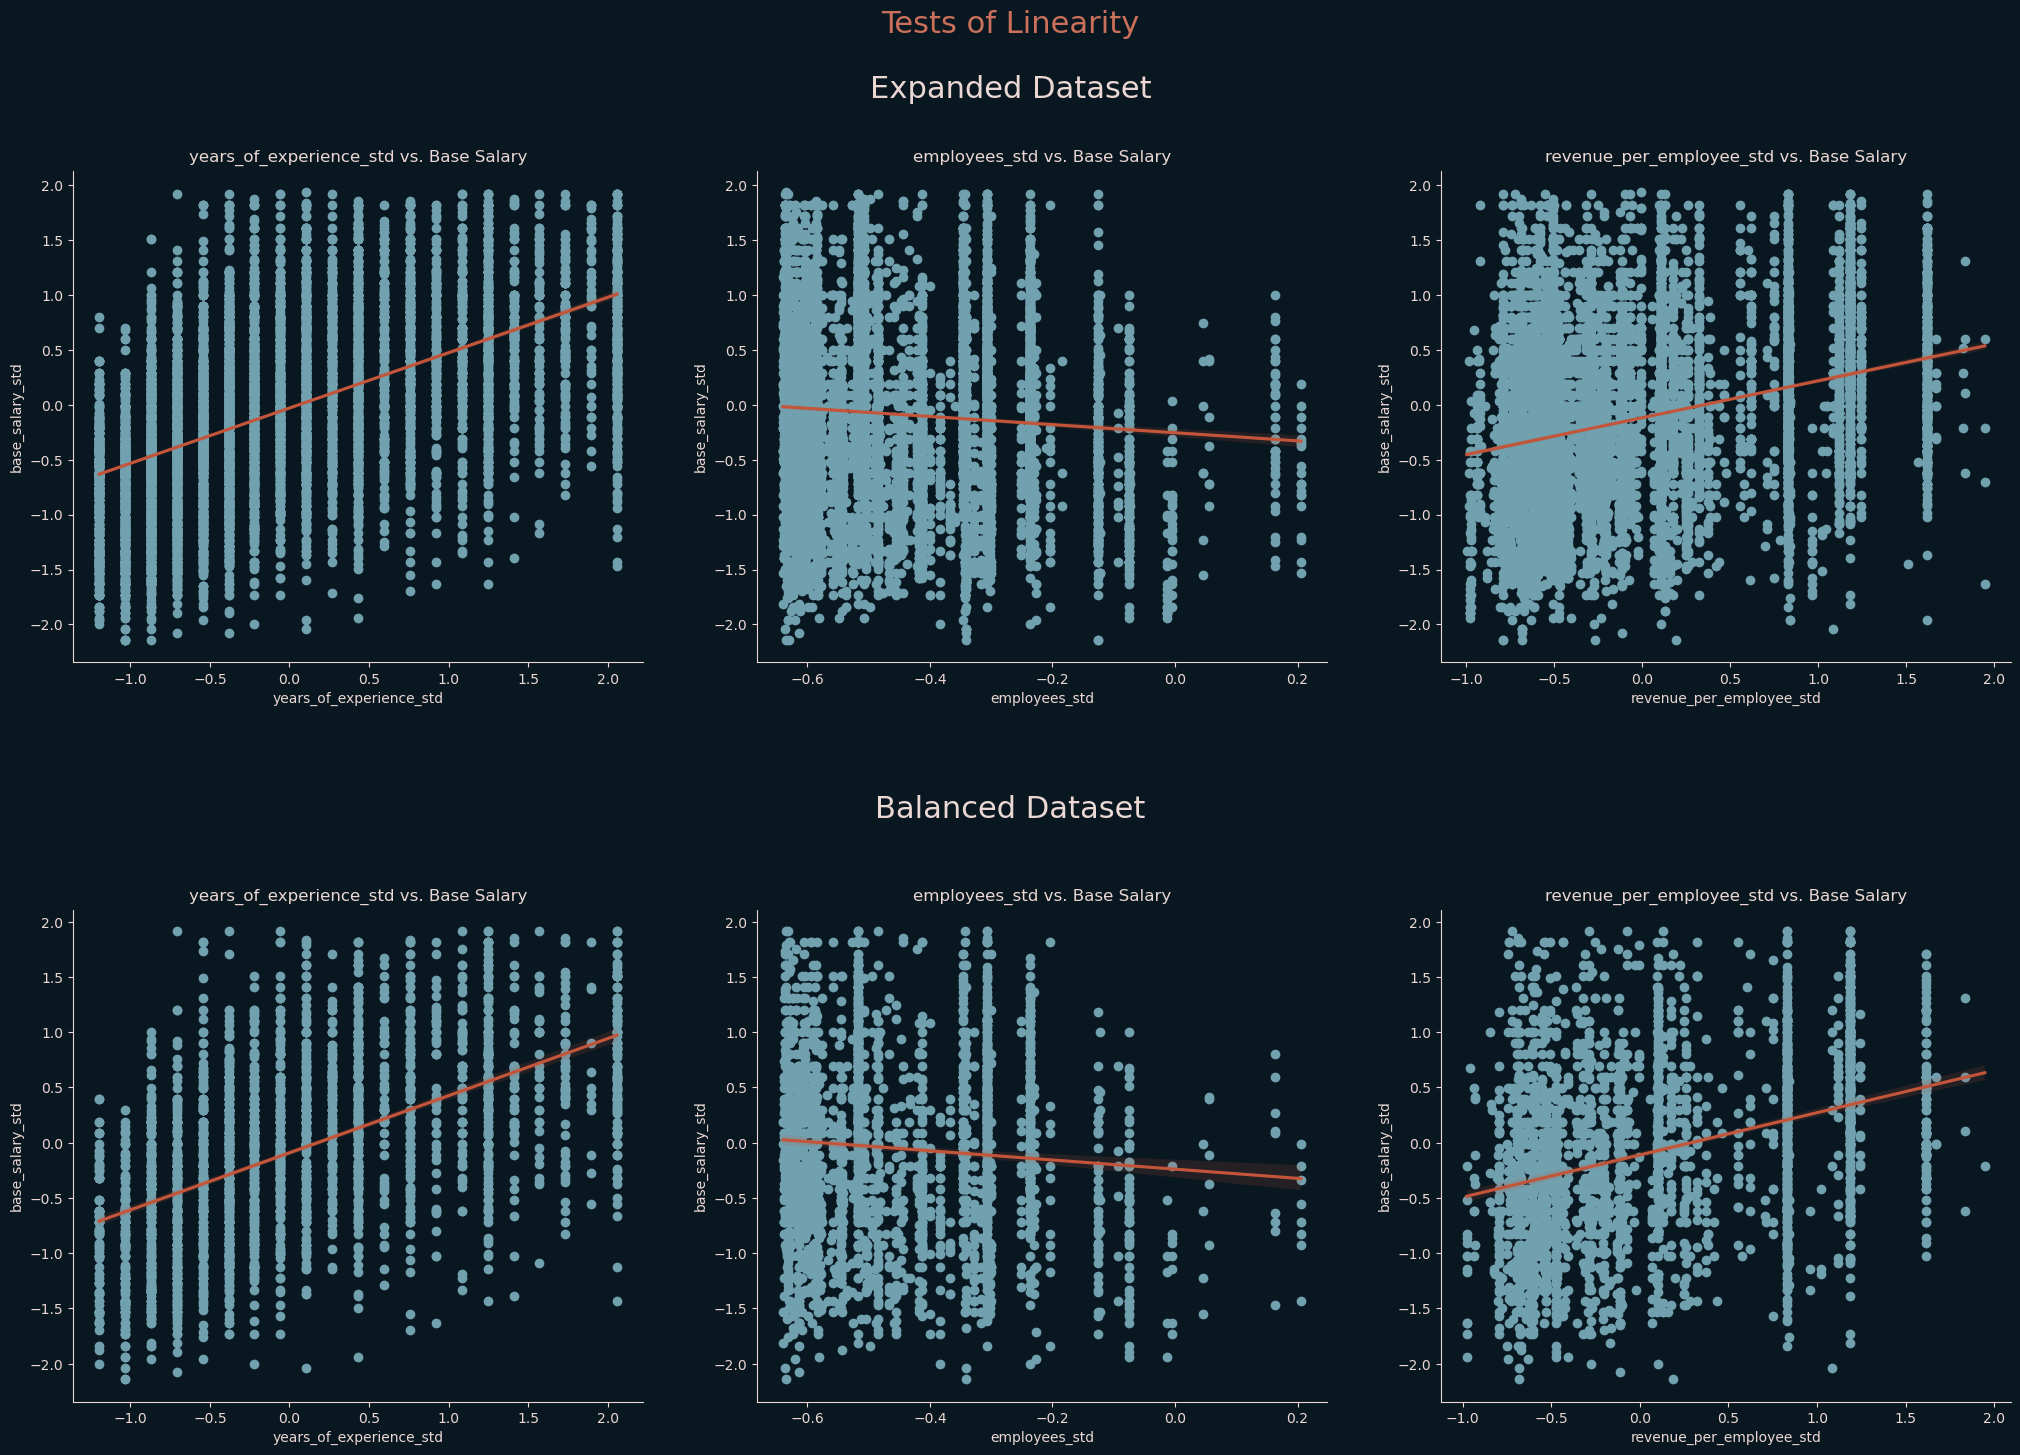

In [68]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 16)); fig.patch.set_facecolor('#091720')
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Tests of Linearity', color='#CB715B', fontsize=22)

fig.text(0.5, 0.93, 'Expanded Dataset', ha='center', va='center', color='#EBD8D4', fontsize=22)
fig.text(0.5, 0.48, 'Balanced Dataset', ha='center', va='center', color='#EBD8D4', fontsize=22)

datasets = [X_full, X]
datasets2 = [y_full, y]
attributes = ['years_of_experience_std', 'employees_std', 'revenue_per_employee_std']

for i in range(2):
    for j in range(3):
        sns.regplot(x=datasets[i][attributes[j]], y=datasets2[i], line_kws={'color': '#C3553A'}, scatter_kws={'color': '#71A0AE', 'alpha': 1}, ax=ax[i, j])
        ax[i, j].set_title(f'{attributes[j]} vs. Base Salary', color='#EBD8D4')
        ax[i, j].set_xlabel(attributes[j], color='#EBD8D4')
        ax[i, j].set_ylabel('base_salary_std', color='#EBD8D4')
        ax[i, j].tick_params(axis='y', colors='#EBD8D4'); ax[i, j].tick_params(axis='x', colors='#EBD8D4')
        ax[i, j].spines['bottom'].set_color('#EBD8D4'); ax[i, j].spines['top'].set_color('#091720') 
        ax[i, j].spines['right'].set_color('#091720'); ax[i, j].spines['left'].set_color('#EBD8D4')
        ax[i, j].set_facecolor('#091720')

plt.show()


# Collinearity

In [69]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF scores for all the predictors
VIFs = [variance_inflation_factor(X_full.values, i) for i in range(X_full.shape[1])]
VIFs_balanced = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("====================================================================================")
print("VIF Scores")
print("====================================================================================")
print(f"{'Expanded Dataset':>63} {'Balanced Dataset':>20}")
print('------------------------------------------------------------------------------------')
for i in range(1, X_full.shape[1]):
    print(f"{X_full.columns[i]:<40} {VIFs[i]:>22.3f} {VIFs_balanced[i-1]:>20.3f}")

VIF Scores
                                               Expanded Dataset     Balanced Dataset
------------------------------------------------------------------------------------
years_of_experience_std                                   1.177                1.289
employees_std                                             1.010                6.186
revenue_per_employee_std                                  1.016                1.074
title_Data Scientist                                      2.990                1.913
title_Hardware Engineer                                   3.393                1.711
title_Marketing                                           1.964                1.285
title_Mechanical Engineer                                 1.727                1.238
title_Product Designer                                    2.514                1.540
title_Product Manager                                     4.148                2.134
title_Software Engineer                               

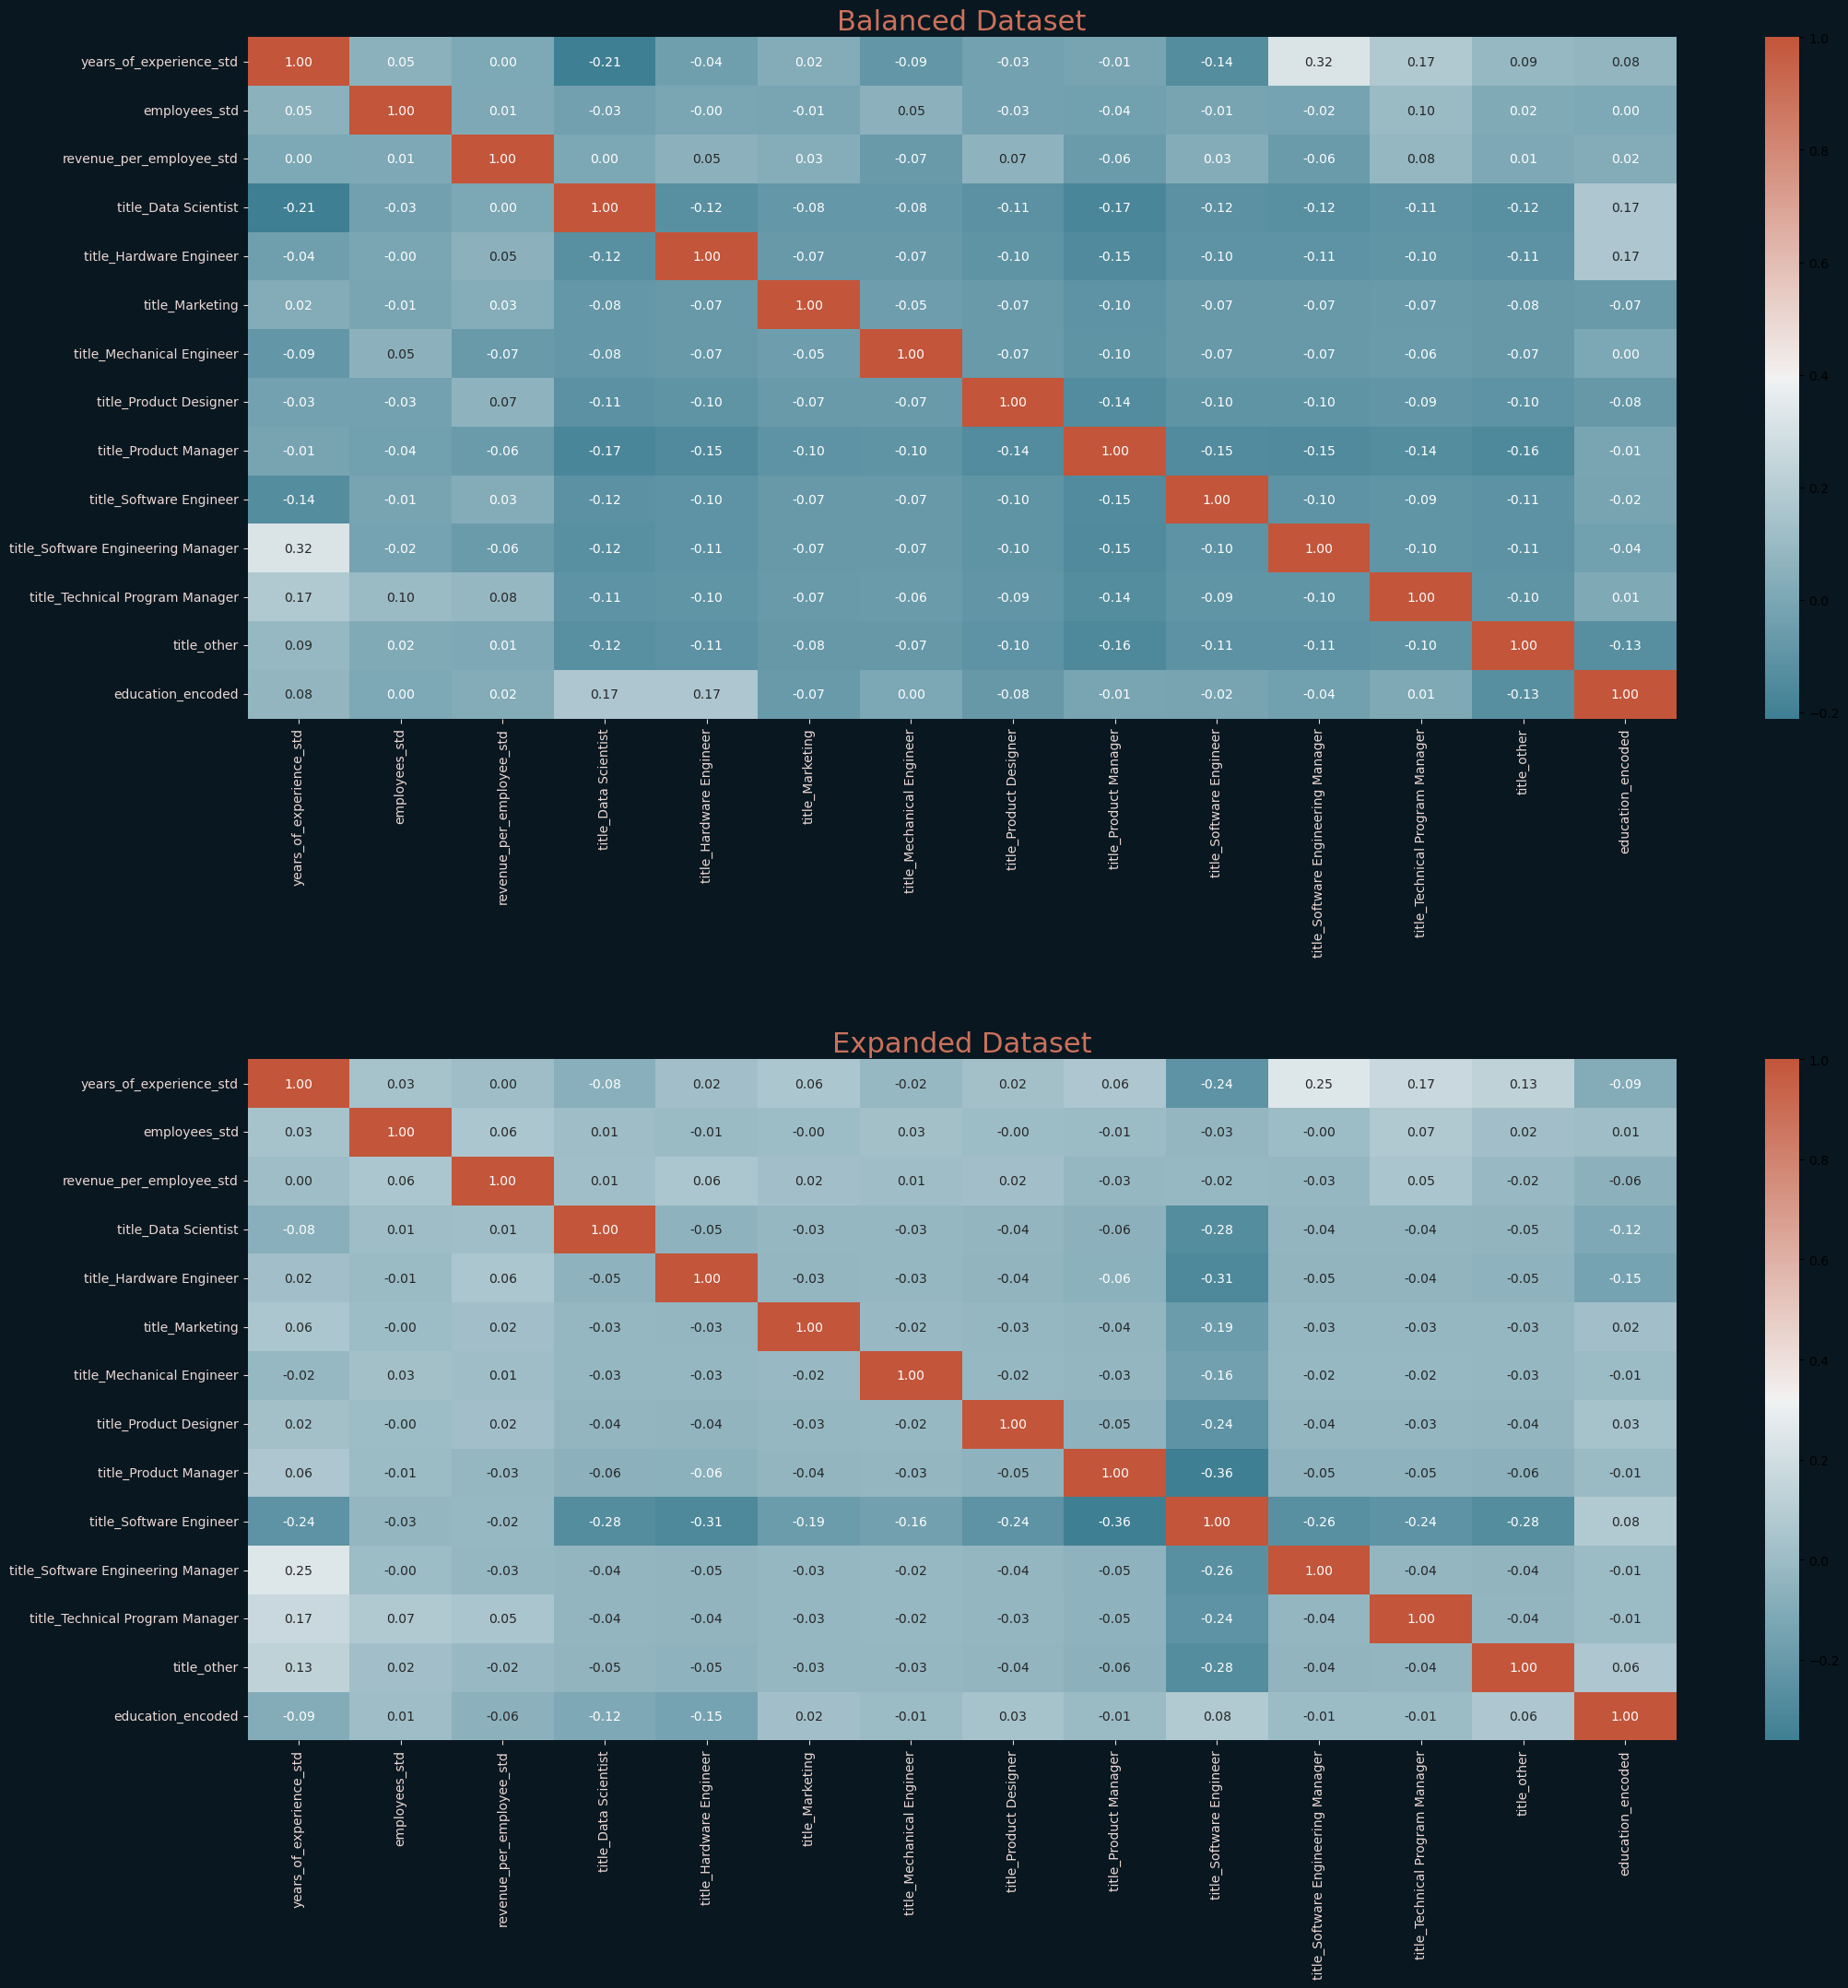

In [70]:
# Compute the correlation matrix
X_full_no_const = X_full.drop(columns='const', axis=1)
corrs = [X, X_full_no_const]

fig, ax = plt.subplots(nrows=2); fig.set_figheight(24); fig.set_figwidth(25); fig.patch.set_facecolor('#091720')
fig.subplots_adjust(hspace=0.5)
for i in range(2):
    corr_matrix = corrs[i].corr()
    ax[i].tick_params(axis='y', colors='#EBD8D4'); ax[i].tick_params(axis='x', colors='#EBD8D4')
    sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(corr_matrix, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), fmt=".2f", ax=ax[i])

ax[0].set_title('Balanced Dataset', color='#CB715B', fontsize=22)
ax[1].set_title('Expanded Dataset', color='#CB715B', fontsize=22)
plt.show()

# Normality of Residuals

In [71]:
import scipy.stats as stats

def plot_residuals(y_true, y_pred, title="Normality of Residuals"):
    residuals = y_true - y_pred

    fig, ax = plt.subplots(ncols=3); fig.set_figheight(8); fig.set_figwidth(25); fig.patch.set_facecolor('#091720')
    fig.suptitle(title, color='#CB715B', fontsize=22)

    # Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=ax[0])
    ax[0].set_title('Checking Our Errors: Q-Q Plot', color='#EBD8D4')
    ax[0].set_xlabel('What We Expected', color='#EBD8D4'); ax[0].set_ylabel('What We Found', color='#EBD8D4')
    ax[0].get_lines()[1].set_color('#C3553A'); ax[0].get_lines()[0].set_color('#71A0AE'); ax[0].get_lines()[1].set_linewidth(3)

    # distribution of residuals
    sns.histplot(residuals, kde=True, ax=ax[1], color='#71A0AE')
    ax[1].set_title('Distribution of Residuals', color='#EBD8D4')
    ax[1].set_xlabel('Residual', color='#EBD8D4'); ax[1].set_ylabel('Frequency', color='#EBD8D4')
    ax[1].get_lines()[0].set_color('#C3553A'); ax[1].get_lines()[0].set_linewidth(3)

    # KDE Plot
    sns.kdeplot(residuals, ax=ax[2], color='#C3553A')
    ax[2].set_title('Checking Our Errors: KDE Plot', color='#EBD8D4')
    ax[2].set_xlabel('Errors', color='#EBD8D4'); ax[2].set_ylabel('Density', color='#EBD8D4')
    ax[2].get_lines()[0].set_linewidth(3)

    # Adjust plot aesthetics
    for i in range(3):
        ax[i].spines['bottom'].set_color('#EBD8D4'); ax[i].spines['top'].set_color('#091720') 
        ax[i].spines['right'].set_color('#091720'); ax[i].spines['left'].set_color('#EBD8D4')
        ax[i].set_facecolor('#091720')
        ax[i].tick_params(axis='y', colors='#EBD8D4'); ax[i].tick_params(axis='x', colors='#EBD8D4')

    plt.show()

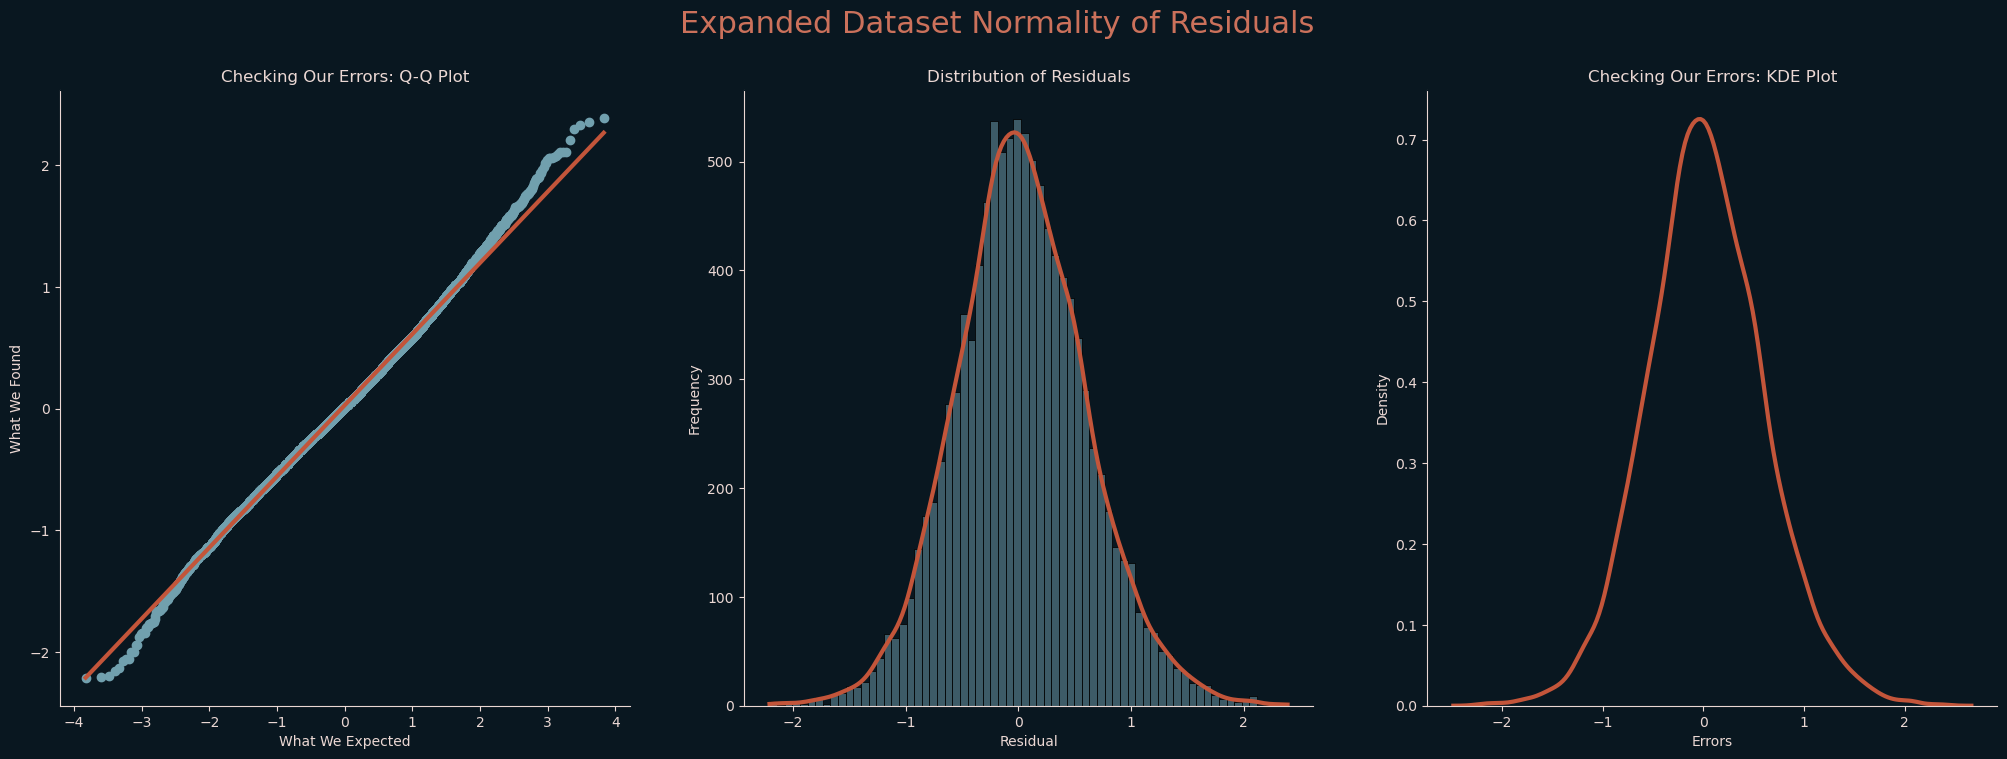

In [72]:
plot_residuals(y_full, y_pred_full, 'Expanded Dataset Normality of Residuals') 

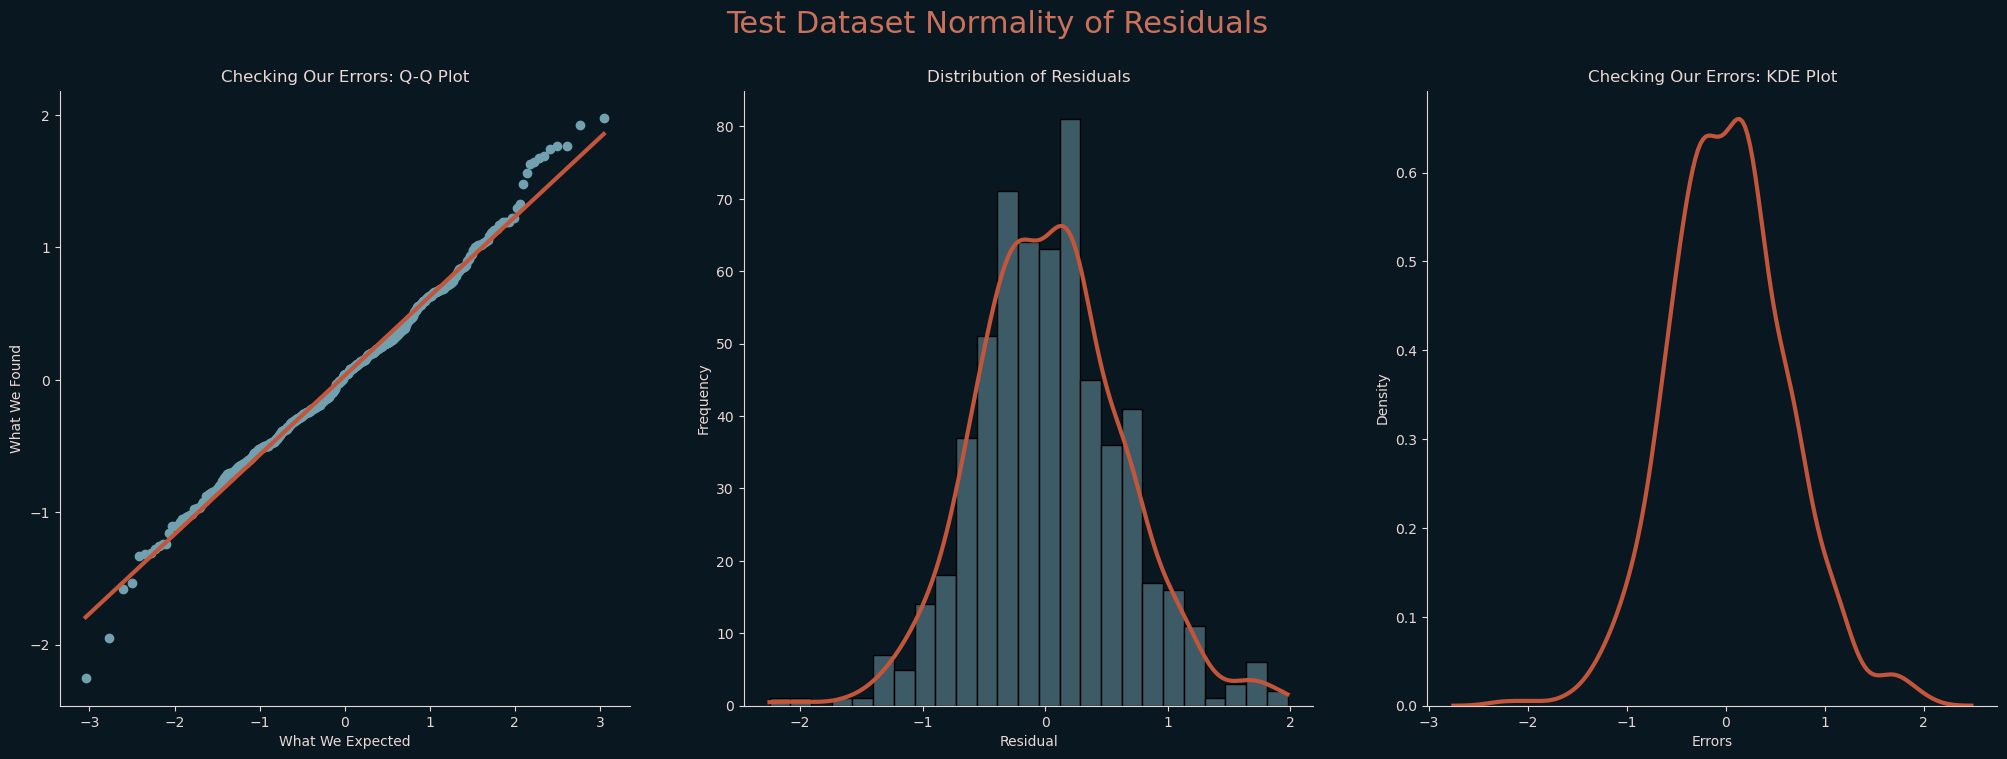

In [73]:
plot_residuals(y_test, y_pred, "Test Dataset Normality of Residuals")

# Homoscedasticity

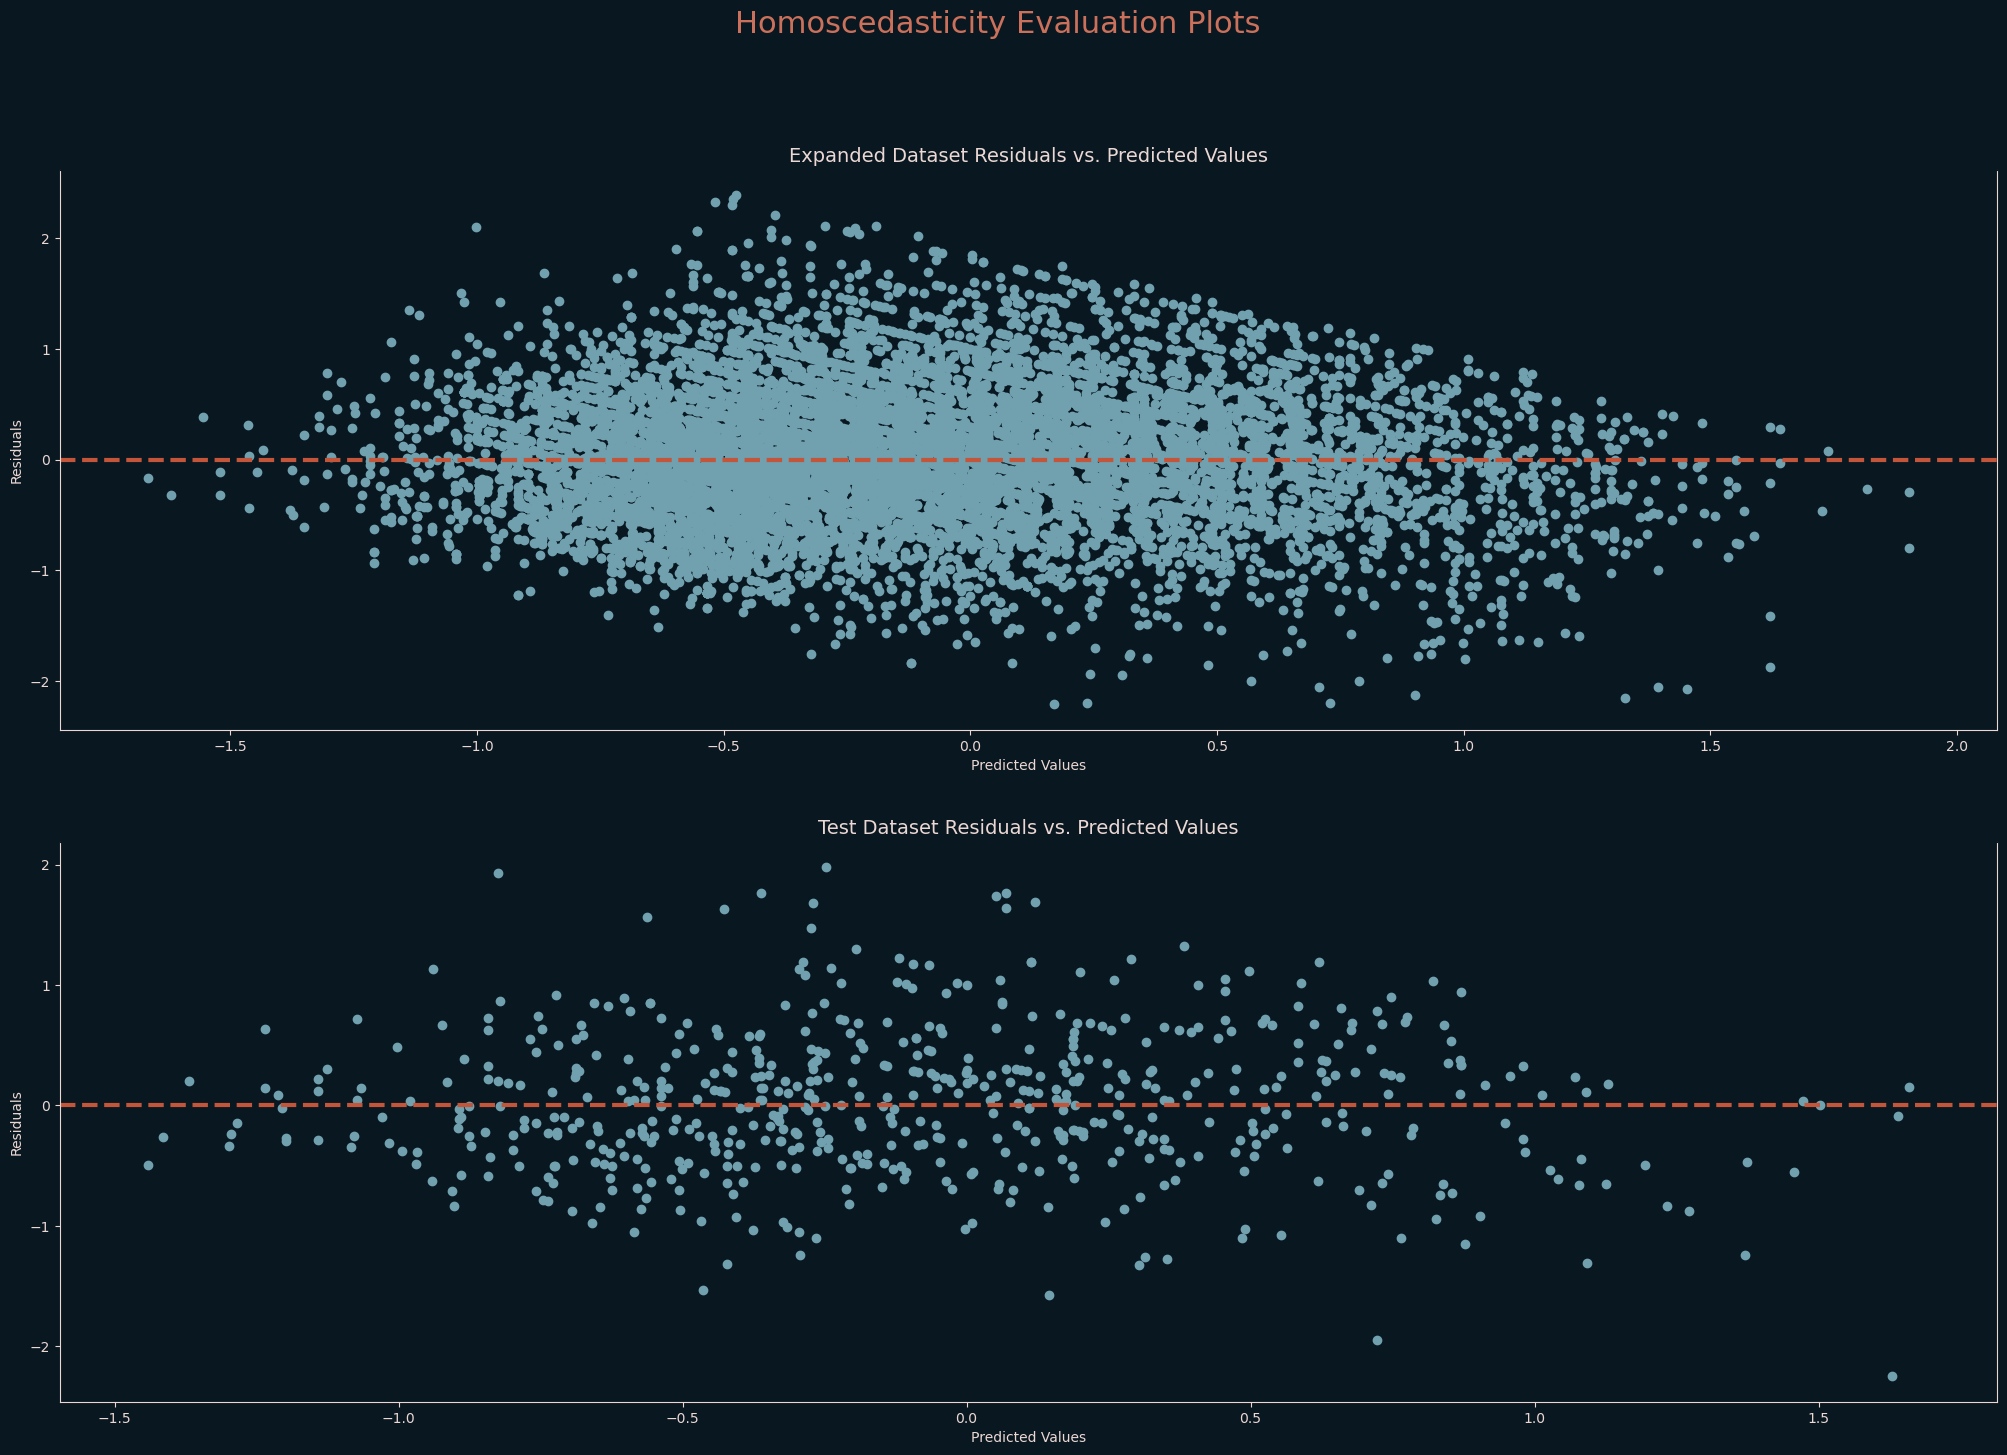

In [74]:
#Residual Plot
residuals_full = y_full - y_pred_full
residuals = y_test - y_pred

fig, ax = plt.subplots(nrows=2); fig.set_figheight(16); fig.set_figwidth(25); fig.patch.set_facecolor('#091720')
fig.suptitle('Homoscedasticity Evaluation Plots', color='#CB715B', fontsize=22)

res = [[y_pred_full, residuals_full], [y_pred, residuals]]

for i in range(2):
    ax[i].scatter(res[i][0], res[i][1], alpha=1, color='#71A0AE')
    ax[i].axhline(y=0, color='#C3553A', linestyle='--', linewidth=3)
    ax[i].set_xlabel('Predicted Values', color='#EBD8D4'); ax[i].set_ylabel('Residuals', color='#EBD8D4')
    ax[i].tick_params(axis='y', colors='#EBD8D4'); ax[i].tick_params(axis='x', colors='#EBD8D4')
    ax[i].spines['bottom'].set_color('#EBD8D4'); ax[i].spines['top'].set_color('#091720') 
    ax[i].spines['right'].set_color('#EBD8D4'); ax[i].spines['left'].set_color('#EBD8D4')
    ax[i].set_facecolor('#091720')
ax[0].set_title('Expanded Dataset Residuals vs. Predicted Values', color='#EBD8D4', fontsize=14)
ax[1].set_title('Test Dataset Residuals vs. Predicted Values', color='#EBD8D4', fontsize=14)

plt.show()

# Independence

In [75]:
print("Avg. Durbin-Watson statistic: " , format(lm.durb_wat_mean, '.3f'))

Avg. Durbin-Watson statistic:  1.963


![decision](images/decision_tree.png) 

# Decision Tree Modeling & Comparison

In [76]:
# Dropping constant in training set for decision tree modeling
X_train_final = X_train_final.drop(columns='const', axis=0)
X_test_final = X_test_final.drop(columns='const', axis=0)

In [77]:
def printAnalysis(dt_params, dt_mse, dt_r2, dt_mse_full, dt_r2_full, dt_mae, dt_mae_full, r_dt_mse, r_dt_mse_full):
    print('Best Parameters')
    max_key_length = max(len(key) for key in dt_params.keys()) + 1
    for x in range(max_key_length + 22): print('=', end='')
    print()
    for key, value in dt_params.items():
        if value:
            print(f'{key:<{max_key_length}} {value:>21}')
        else:
            print(f'{key:<{max_key_length}} {"None":>21}')
    
    for x in range(max_key_length + 22): print('=', end='')
    print()
    # Print the results
    print(f'{"Test Dataset":>23} {"Expanded Dataset":>10}')
    print(f'{"MSE:"} {dt_mse:>18.3f} {dt_mse_full:>16.3f}')
    print(f'{"RMSE:"} {r_dt_mse:>17.3f} {r_dt_mse_full:>16.3f}')
    print(f'{"MAE:"} {dt_mae:>18.3f} {dt_mae_full:>16.3f}')
    print(f'{"r^2:"} {dt_r2:>18.3f} {dt_r2_full:>16.3f}')

In [78]:
def treeAnalysis(grid_search, dt_params):
    best_estimator = grid_search.best_estimator_

    # Predict
    dt_pred_full = best_estimator.predict(X_full_no_const)
    dt_pred = best_estimator.predict(X_test_final)

    # Calculate evaluation metrics
    dt_mse_full = mean_squared_error(y_full, dt_pred_full)
    r_dt_mse_full = np.sqrt(dt_mse_full)
    dt_mae_full = mean_absolute_error(y_full, dt_pred_full)
    dt_r2_full = r2_score(y_full, dt_pred_full)

    dt_mse = mean_squared_error(y_test, dt_pred)
    r_dt_mse = np.sqrt(dt_mse)
    dt_mae = mean_absolute_error(y_test, dt_pred)
    dt_r2 = r2_score(y_test, dt_pred)
    
    printAnalysis(dt_params, dt_mse, dt_r2, dt_mse_full, dt_r2_full, dt_mae, dt_mae_full, r_dt_mse, r_dt_mse_full)
    return (dt_pred_full, dt_pred, dt_mse, dt_mse_full, dt_mae, dt_mae_full, dt_r2, dt_r2_full, r_dt_mse, r_dt_mse_full)

In [79]:
#Original Grid Search, this takes a long time to run, the best parameters found in the search are fitted in the next cell
#param_grid = {'min_samples_split': [2, 5, 10, 20, 50, 100],
#              'min_samples_leaf': [1, 2, 5, 10, 20],
#              'max_depth': [None, 5, 10, 15, 20],
#              'max_features': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
#              'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
#              'max_leaf_nodes': [None, 10, 50, 100, 500],
#              'random_state': [42]}

#dt_model = DecisionTreeRegressor(random_state=42)
#grid_search = GridSearchCV(dt_model, param_grid, cv=5, n_jobs=-1)
#grid_search.fit(X_train_final, y_train)

#dt_params = grid_search.best_params_

In [80]:
param_grid = {'min_samples_split': [50],
              'min_samples_leaf': [5],
              'max_depth': [None],
              'max_features': [9],
              'criterion': ['squared_error'],
              'max_leaf_nodes': [None],
              'random_state': [42]}

dt_model = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(dt_model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_final, y_train)

dt_params = grid_search.best_params_

In [81]:
dt_pred_full, dt_pred, dt_mse, dt_mse_full, dt_mae, dt_mae_full, dt_r2, dt_r2_full, r_dt_mse, r_dt_mse_full = treeAnalysis(grid_search, dt_params)

Best Parameters
criterion                  squared_error
max_depth                           None
max_features                           9
max_leaf_nodes                      None
min_samples_leaf                       5
min_samples_split                     50
random_state                          42
           Test Dataset Expanded Dataset
MSE:              0.371            0.385
RMSE:             0.609            0.621
MAE:              0.473            0.480
r^2:              0.451            0.340


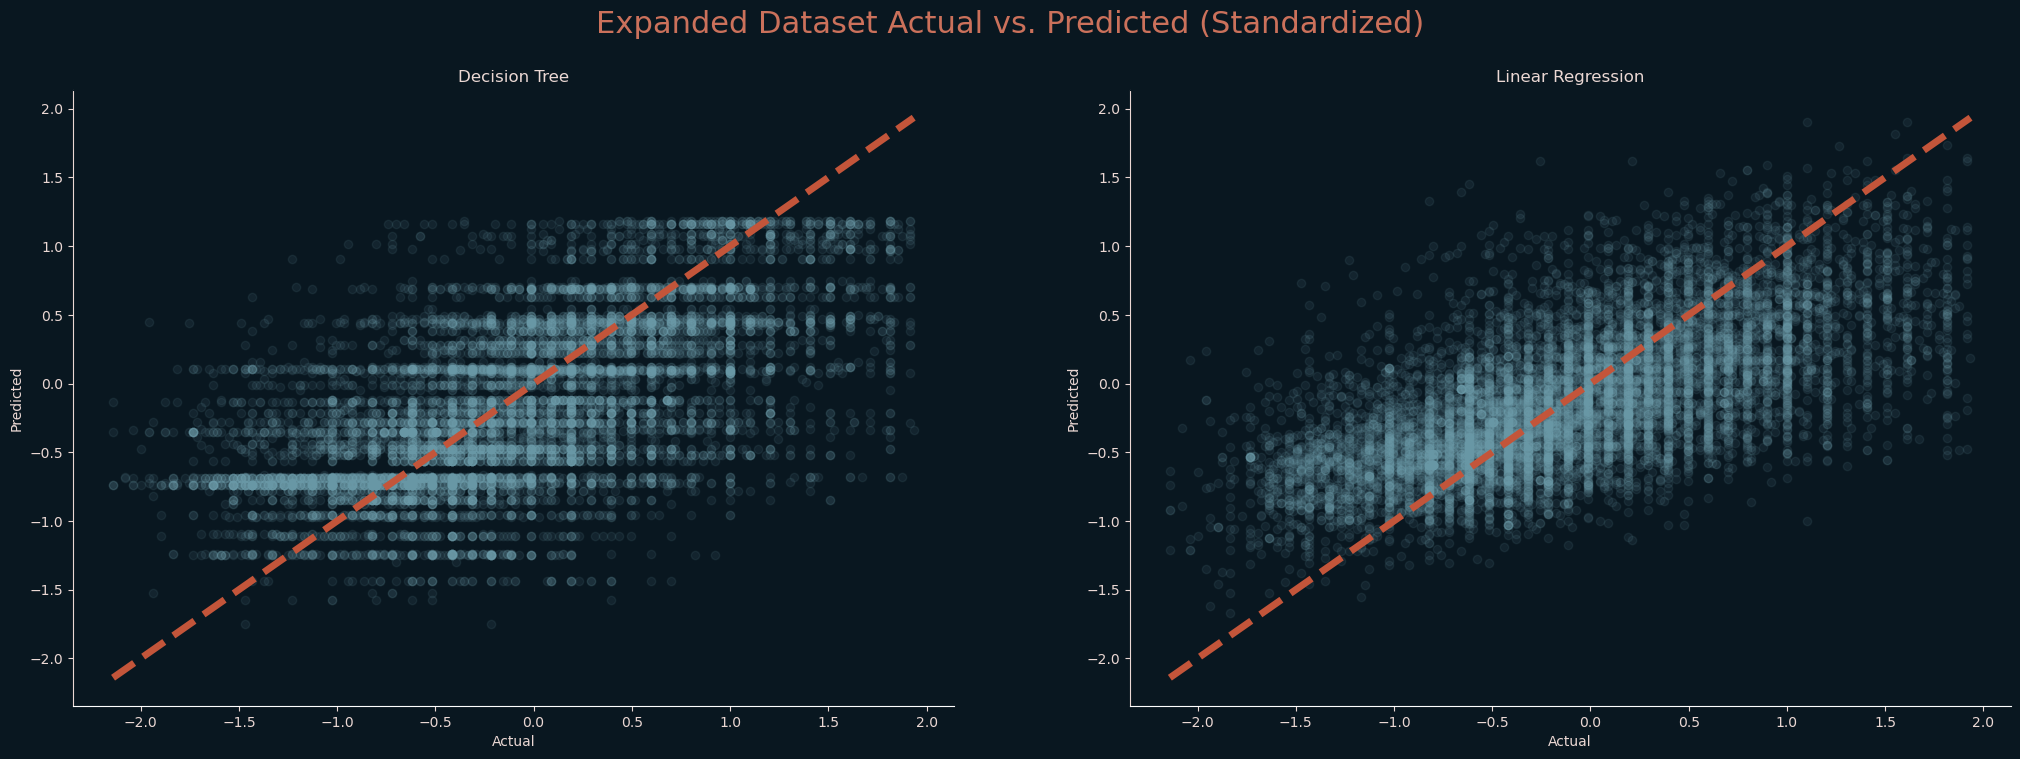

In [82]:
# plot actual vs. predicted of both models
fig, ax = plt.subplots(ncols=2); fig.set_figheight(8); fig.set_figwidth(25); fig.patch.set_facecolor('#091720')
fig.suptitle('Expanded Dataset Actual vs. Predicted (Standardized)', color='#CB715B', fontsize=22)

plt.sca(ax[0])
plt.scatter(y_full, dt_pred_full, color='#71A0AE', label='Decision Tree', alpha=.1)
plt.plot([min(y_full), max(y_full)], [min(y_full), max(y_full)], color='#C3553A', linestyle='--', linewidth=5)
plt.title('Decision Tree', color='#EBD8D4'); plt.ylabel('Predicted', color='#EBD8D4'); plt.xlabel('Actual', color='#EBD8D4')

plt.sca(ax[1])
plt.scatter(y_full, y_pred_full, color='#71A0AE', label='Linear Regression', alpha=.1)
plt.plot([min(y_full), max(y_full)], [min(y_full), max(y_full)], color='#C3553A', linestyle='--', linewidth=5)
plt.title('Linear Regression', color='#EBD8D4'); plt.ylabel('Predicted', color='#EBD8D4'); plt.xlabel('Actual', color='#EBD8D4')

for i in range(2):
    ax[i].spines['bottom'].set_color('white'); ax[i].spines['top'].set_color('#091720') 
    ax[i].spines['right'].set_color('#091720'); ax[i].spines['left'].set_color('#EBD8D4')
    ax[i].set_facecolor('#091720')
    ax[i].tick_params(axis='y', colors='#EBD8D4'); ax[i].tick_params(axis='x', colors='#EBD8D4')

plt.show()

In [83]:
print(f'{"Method":>15}{"Test Data":>20} {"Expanded Data":>15}')
print(f'{"MSE"}{"LR":>12} {lr_mse:>19.3f} {lr_mse_full:>15.3f}')
print(f'{"DT":>15} {dt_mse:>19.3f} {dt_mse_full:>15.3f}')
print()
print(f'{"RMSE"}{"LR":>11} {r_lr_mse:>19.3f} {r_lr_mse_full:>15.3f}')
print(f'{"DT":>15} {r_dt_mse:>19.3f} {r_dt_mse_full:>15.3f}')
print()
print(f'{"MAE"}{"LR":>12} {lr_mae:>19.3f} {lr_mae_full:>15.3f}')
print(f'{"DT":>15} {dt_mae:>19.3f} {dt_mae_full:>15.3f}')
print()
print(f'{"r^2"}{"LR":>12} {lr_r2:>19.3f} {lr_r2_full:>15.3f}')
print(f'{"DT":>15} {dt_r2:>19.3f} {dt_r2_full:>15.3f}')

         Method           Test Data   Expanded Data
MSE          LR               0.360           0.343
             DT               0.371           0.385

RMSE         LR               0.600           0.585
             DT               0.609           0.621

MAE          LR               0.471           0.343
             DT               0.473           0.480

r^2          LR               0.469           0.412
             DT               0.451           0.340


![gradient](images/gradient.png) 

# Gradient Descent, Because Why Not?

In [84]:
import lab_utils_multi
from lab_utils_multi import  run_gradient_descent
from lab_utils_multi import  norm_plot, plt_equal_scale, plot_cost_i_w
from lab_utils_common import dlc

In [85]:
X_train_gd = X_train_final.values
y_train_gd = np.array(y_train)
X_test_gd = X_test_final.values
y_test_gd  = np.array(y_test)
X_features = X_train_final.columns.values

In [86]:
w_norm, b_norm, hist = run_gradient_descent(X_train_gd, y_train_gd, 1000, 1.0e-1, )

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 3.11206e-01  3.8e-02  1.4e-03  2.0e-02 -9.3e-04 -5.5e-03 -3.8e-01 -1.4e-02 -2.0e-01  9.3e-03  5.5e-02
      100 1.64102e-01  5.0e-01 -2.4e-02  3.9e-01  1.3e-01 -2.6e-01 -1.6e-04  8.5e-03 -2.1e-03 -1.1e-02  1.1e-02
      200 1.59368e-01  5.0e-01 -1.1e-01  4.0e-01  2.1e-01 -3.4e-01  5.0e-05  7.6e-03 -3.0e-04 -5.3e-03  6.4e-03
      300 1.57601e-01  5.0e-01 -1.7e-01  4.0e-01  2.5e-01 -4.0e-01  7.3e-05  6.1e-03 -6.0e-05 -3.2e-03  5.0e-03
      400 1.56560e-01  5.0e-01 -2.3e-01  4.0e-01  2.7e-01 -4.5e-01  7.3e-05  4.9e-03  1.0e-05 -2.4e-03  4.3e-03
      500 1.55808e-01  5.0e-01 -2.7e-01  4.0e-01  3.0e-01 -4.9e-01  6.7e-05  4.0e-03  3.1e-05 -2.0e-03  3.7e-03
      600 1.55213e-01  5.0e-01 -3.1e-01  4.0e-01  3.2e-01 -5.2e-01  6.0e-05  3.2e-03  3.6e-05 -1.8e-03  

In [87]:
y_pred_gd = np.dot(X_test_gd, w_norm) + b_norm
y_pred_full_gd = np.dot(X_full.drop(columns=['const']).values, w_norm) + b_norm

gd_mse = mean_squared_error(y_test_gd, y_pred_gd)
gd_mse_full = mean_squared_error(y_full, y_pred_full)

r_gd_mse = np.sqrt(gd_mse)
r_gd_mse_full = np.sqrt(gd_mse_full)

gd_mae = mean_absolute_error(y_test_gd, y_pred_gd)
gd_mae_full = mean_absolute_error(y_full, y_pred_full)

gd_r2 = r2_score(y_test_gd, y_pred_gd)
gd_r2_full = r2_score(y_full, y_pred_full)

In [88]:
print(f'{"Method":>15}{"Test Data":>20} {"Expanded Data":>15}')
print(f'{"MSE"}{"LR":>12} {lr_mse:>19.3f} {lr_mse_full:>15.3f}')
print(f'{"DT":>15} {dt_mse:>19.3f} {dt_mse_full:>15.3f}')
print(f'{"GD":>15} {gd_mse:>19.3f} {gd_mse_full:>15.3f}')
print()
print(f'{"RMSE"}{"LR":>11} {r_lr_mse:>19.3f} {r_lr_mse_full:>15.3f}')
print(f'{"DT":>15} {r_dt_mse:>19.3f} {r_dt_mse_full:>15.3f}')
print(f'{"GD":>15} {r_gd_mse:>19.3f} {r_gd_mse_full:>15.3f}')
print()
print(f'{"MAE"}{"LR":>12} {lr_mae:>19.3f} {lr_mae_full:>15.3f}')
print(f'{"DT":>15} {dt_mae:>19.3f} {dt_mae_full:>15.3f}')
print(f'{"GD":>15} {gd_mae:>19.3f} {gd_mae_full:>15.3f}')
print()
print(f'{"r^2"}{"LR":>12} {lr_r2:>19.3f} {lr_r2_full:>15.3f}')
print(f'{"DT":>15} {dt_r2:>19.3f} {dt_r2_full:>15.3f}')
print(f'{"GD":>15} {gd_r2:>19.3f} {gd_r2_full:>15.3f}')

         Method           Test Data   Expanded Data
MSE          LR               0.360           0.343
             DT               0.371           0.385
             GD               0.363           0.343

RMSE         LR               0.600           0.585
             DT               0.609           0.621
             GD               0.602           0.585

MAE          LR               0.471           0.343
             DT               0.473           0.480
             GD               0.475           0.457

r^2          LR               0.469           0.412
             DT               0.451           0.340
             GD               0.464           0.412


In [89]:
# Hyper parameter tuning again... umm... ya... 
w_norm, b_norm, hist = run_gradient_descent(X_train_gd, y_train_gd, 400, 1, )

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 2.01616e-01  3.8e-01  1.4e-02  2.0e-01 -9.3e-03 -5.5e-02 -3.8e-01 -1.4e-02 -2.0e-01  9.3e-03  5.5e-02
       40 1.56460e-01  5.0e-01 -2.4e-01  4.0e-01  2.8e-01 -4.5e-01  7.4e-05  4.9e-03  1.8e-05 -2.3e-03  4.2e-03
       80 1.54254e-01  5.0e-01 -3.6e-01  4.0e-01  3.5e-01 -5.8e-01  4.9e-05  2.1e-03  3.5e-05 -1.6e-03  2.5e-03
      120 1.53040e-01  4.9e-01 -4.2e-01  3.9e-01  4.1e-01 -6.6e-01  4.0e-05  9.1e-04  3.1e-05 -1.3e-03  1.7e-03
      160 1.52254e-01  4.9e-01 -4.5e-01  3.9e-01  4.6e-01 -7.2e-01  3.5e-05  4.3e-04  2.7e-05 -1.1e-03  1.3e-03
      200 1.51726e-01  4.9e-01 -4.6e-01  3.9e-01  5.0e-01 -7.7e-01  2.9e-05  2.2e-04  2.3e-05 -9.5e-04  1.0e-03
      240 1.51368e-01  4.9e-01 -4.6e-01  3.9e-01  5.3e-01 -8.1e-01  2.5e-05  1.3e-04  2.0e-05 -7.9e-04  

In [90]:
y_pred_gd = np.dot(X_test_gd, w_norm) + b_norm
y_pred_full_gd = np.dot(X_full.drop(columns=['const']).values, w_norm) + b_norm

gd_mse = mean_squared_error(y_test_gd, y_pred_gd)
gd_mse_full = mean_squared_error(y_full, y_pred_full)

r_gd_mse = np.sqrt(gd_mse)
r_gd_mse_full = np.sqrt(gd_mse_full)

gd_mae = mean_absolute_error(y_test_gd, y_pred_gd)
gd_mae_full = mean_absolute_error(y_full, y_pred_full)

gd_r2 = r2_score(y_test_gd, y_pred_gd)
gd_r2_full = r2_score(y_full, y_pred_full)

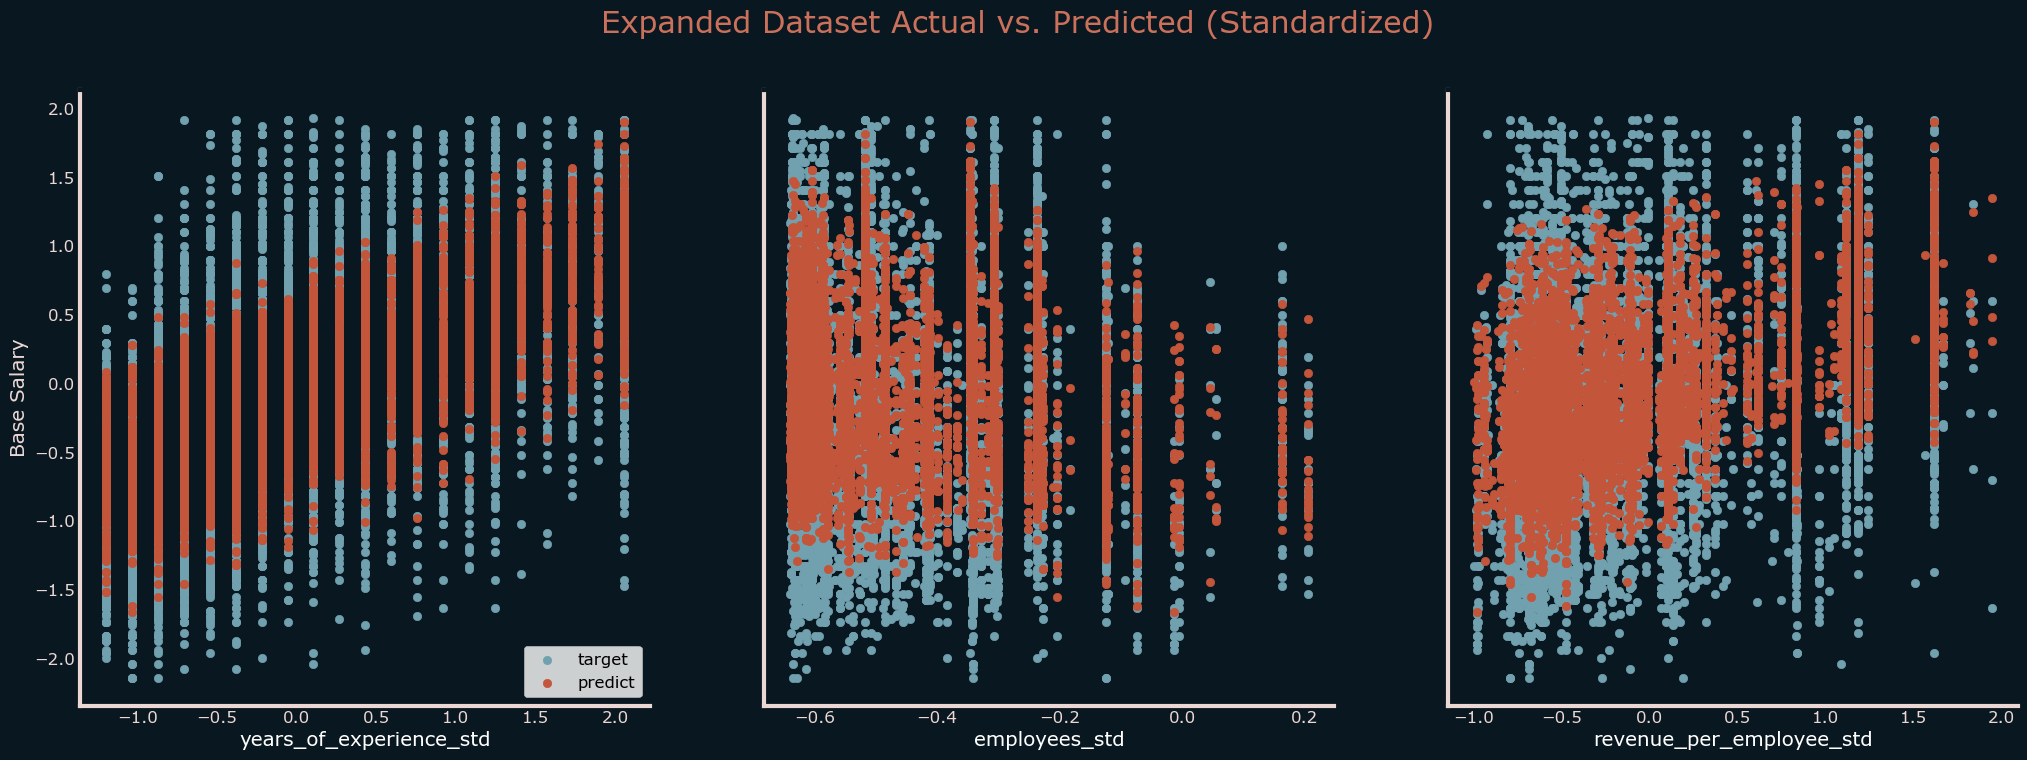

In [91]:
# plot predictions and targets versus original features    
fig,ax=plt.subplots(ncols=3,sharey=True); fig.set_figheight(8); fig.set_figwidth(25); fig.patch.set_facecolor('#091720')
fig.suptitle('Expanded Dataset Actual vs. Predicted (Standardized)', color='#CB715B', fontsize=22)

for i in range(len(ax)):
    ax[i].scatter(X_full.drop(columns=['const']).values[:,i], y_full, label = 'target', color='#71A0AE', alpha=1)
    ax[i].set_xlabel(X_features[i], color='white')
    ax[i].scatter(X_full.drop(columns=['const']).values[:,i], y_pred_full, color='#C3553A', label = 'predict', alpha=1)
    ax[i].spines['bottom'].set_color('#EBD8D4'); ax[i].spines['top'].set_color('#091720') 
    ax[i].spines['right'].set_color('#091720'); ax[i].spines['left'].set_color('#EBD8D4')
    ax[i].set_facecolor('#091720')
    ax[i].tick_params(axis='x', colors='#EBD8D4'); ax[i].tick_params(axis='y', colors='#EBD8D4')
    
ax[0].set_ylabel("Base Salary", color='#EBD8D4'); ax[0].legend()

plt.show()

![eval](images/eval.png) 

In [92]:
print(f'{"Method":>15}{"Test Data":>20} {"Expanded Data":>15}')
print(f'{"MSE"}{"LR":>12} {lr_mse:>19.3f} {lr_mse_full:>15.3f}')
print(f'{"DT":>15} {dt_mse:>19.3f} {dt_mse_full:>15.3f}')
print(f'{"GD":>15} {gd_mse:>19.3f} {gd_mse_full:>15.3f}')
print()
print(f'{"RMSE"}{"LR":>11} {r_lr_mse:>19.3f} {r_lr_mse_full:>15.3f}')
print(f'{"DT":>15} {r_dt_mse:>19.3f} {r_dt_mse_full:>15.3f}')
print(f'{"GD":>15} {r_gd_mse:>19.3f} {r_gd_mse_full:>15.3f}')
print()
print(f'{"MAE"}{"LR":>12} {lr_mae:>19.3f} {lr_mae_full:>15.3f}')
print(f'{"DT":>15} {dt_mae:>19.3f} {dt_mae_full:>15.3f}')
print(f'{"GD":>15} {gd_mae:>19.3f} {gd_mae_full:>15.3f}')
print()
print(f'{"r^2"}{"LR":>12} {lr_r2:>19.3f} {lr_r2_full:>15.3f}')
print(f'{"DT":>15} {dt_r2:>19.3f} {dt_r2_full:>15.3f}')
print(f'{"GD":>15} {gd_r2:>19.3f} {gd_r2_full:>15.3f}')

         Method           Test Data   Expanded Data
MSE          LR               0.360           0.343
             DT               0.371           0.385
             GD               0.359           0.343

RMSE         LR               0.600           0.585
             DT               0.609           0.621
             GD               0.599           0.585

MAE          LR               0.471           0.343
             DT               0.473           0.480
             GD               0.470           0.457

r^2          LR               0.469           0.412
             DT               0.451           0.340
             GD               0.469           0.412


# Interpreting the metrics
### r^2
Based on the testing data, the r^2 value of the multivariate linear regression model and the gradient descent model are equal with a value of .469.  This mean that the about 46.9% of the variance in the dependent variable is explained by the model when tested against the testing data.  This is higher than the r^2 value of the decision tree model with a value .451.

The same happens when tested against the Expanded dataset where r^2 is .412 for the multivariate linear regression model and the gradient descent model.  The decision tree has an r^2 value of .340 when tested against the expanded dataset.

### RMSE
When evaluating the RMSE of the models, we see a similar pattern.  Against the test data, the RMSE of the multivariate linear regression model is .600 and for the gradient descent model the value is .599.  The decision tree model is slightly higher with a value of .609.  These values indicate how far the predicted values are from the actual values, so the lower values are more accurate.

This disparity widens when the expanded dataset is tested against the models.  Here we see the RMSE of the multivariate linear regression and gradient descent models equal to .585.  The decision tree RMSE value is .621.

# Estimations

Based on the metrics above, the multiple linear regression model and the gradient descent model perform about equally when looking at r^2, MSE, and RMSE.  Looking at MAE, the multiple linear regression model has a significantly lower MAE score (.310) on the expanded dataset when compared to the gradient descent model (.432).  It is for this reason we believe the Multiple Linear regression model is the best model and will be the model used to make predictions.

In [93]:
def predictSalary():
    # create list for input values
    inputs = []
    
    print("Hello, here we are going to prompt you for values that will be used to predict the base salary\n" +
          "of an individual with a tech career or looking for a tech career.\n\n" +
          "If an error occurs, please rerun the cell and try again.\n")
        
    #get values from user for prediction    
    print("How many years of experience does the individual have?")
    inputs.append(float(input()))
    print("How many total employees does the hiring company have?")
    inputs.append(float(input()))
    print("What is the revenue per employee statistic of the hiring company?")
    inputs.append(float(input()))
    print("What is the title of the position in question?\n")
    print("\t1. Data Scientist")
    print("\t2. Hardware Engineer")
    print("\t3. Marketing")
    print("\t4. Mechanical Engineer")
    print("\t5. Product Designer")
    print("\t6. Product Manager")
    print("\t7. Software Engineer")
    print("\t8. Software Engineering Manager")
    print("\t9. Technical Program Manager")
    print("\t10. Business Analyst")
    print("\t11. Other\n")
    print("Enter the corresponding number")
    pos = int(input())
    
    #translating title input into list corresponding to encoding of model then adding list to inputs
    if pos == 1:
        pos = [1,0,0,0,0,0,0,0,0,0]
        for x in pos: inputs.append(x)
    elif pos == 2:
        pos = [0,1,0,0,0,0,0,0,0,0]
        for x in pos: inputs.append(x)
    elif pos == 3:
        pos = [0,0,1,0,0,0,0,0,0,0]
        for x in pos: inputs.append(x)
    elif pos == 4:
        pos = [0,0,0,1,0,0,0,0,0,0]
        for x in pos: inputs.append(x)
    elif pos == 5:
        pos = [0,0,0,0,1,0,0,0,0,0]
        for x in pos: inputs.append(x)
    elif pos == 6:
        pos = [0,0,0,0,0,1,0,0,0,0]
        for x in pos: inputs.append(x)
    elif pos == 7:
        pos = [0,0,0,0,1,0,1,0,0,0]
        for x in pos: inputs.append(x)
    elif pos == 8:
        pos = [0,0,0,0,1,0,0,1,0,0]
        for x in pos: inputs.append(x)
    elif pos == 9:
        pos = [0,0,0,0,1,0,0,0,1,0]
        for x in pos: inputs.append(x)
    elif pos == 10:
        pos = [0,0,0,0,0,0,0,0,0,0]
        for x in pos: inputs.append(x)
    elif pos == 11:
        pos = [0,0,0,0,0,0,0,0,0,1]
        for x in pos: inputs.append(x)
    
    #prompt for education background
    print("Does the individual have a Master's Degree or PHD? (Y/N)")
    edu = input()
    if (edu == 'Y') or (edu == 'y'):
        inputs.append(1)
    else: inputs.append(0)
    
    # standardization of quantitative inputs
    inputs[0] = (inputs[0] - means['years_of_experience'])  / stds['years_of_experience']
    inputs[1] = (inputs[1] - means['employees'])            / stds['employees']
    inputs[2] = (inputs[2] - means['revenue_per_employee']) / stds['revenue_per_employee']
    
    #calculate prediction using model parameters
    prediction = sum((lm.params[1:] * inputs)) + lm.params[0]
    
    #unstandardize and print prediction
    prediction = (prediction * stds['base_salary']) + means['base_salary']
    print('\nThe estimated base salary of an employee matching these parameters is: $' + str(prediction.round(2)))

In [94]:
predictSalary()

Hello, here we are going to prompt you for values that will be used to predict the base salary
of an individual with a tech career or looking for a tech career.

If an error occurs, please rerun the cell and try again.

How many years of experience does the individual have?


 3


How many total employees does the hiring company have?


 200000


What is the revenue per employee statistic of the hiring company?


 200000


What is the title of the position in question?

	1. Data Scientist
	2. Hardware Engineer
	3. Marketing
	4. Mechanical Engineer
	5. Product Designer
	6. Product Manager
	7. Software Engineer
	8. Software Engineering Manager
	9. Technical Program Manager
	10. Business Analyst
	11. Other

Enter the corresponding number


 1


Does the individual have a Master's Degree or PHD? (Y/N)


 y



The estimated base salary of an employee matching these parameters is: $119498.11


In [95]:
predictSalary()

Hello, here we are going to prompt you for values that will be used to predict the base salary
of an individual with a tech career or looking for a tech career.

If an error occurs, please rerun the cell and try again.

How many years of experience does the individual have?


 3


How many total employees does the hiring company have?


 200000


What is the revenue per employee statistic of the hiring company?


 200000


What is the title of the position in question?

	1. Data Scientist
	2. Hardware Engineer
	3. Marketing
	4. Mechanical Engineer
	5. Product Designer
	6. Product Manager
	7. Software Engineer
	8. Software Engineering Manager
	9. Technical Program Manager
	10. Business Analyst
	11. Other

Enter the corresponding number


 10


Does the individual have a Master's Degree or PHD? (Y/N)


 y



The estimated base salary of an employee matching these parameters is: $87093.04
